In [4]:
import numpy as np
from scipy.linalg import sqrtm, inv
import matplotlib.pyplot as plt
from scipy.linalg import eig
from cycler import cycler
import pandas as pd
import math
import seaborn as sns

plt.rcParams['axes.prop_cycle'] = cycler(color=plt.cm.tab20.colors)

level = [1,2,3,5,7,10,20,30,50,70,100,125,150, 175, 200, 225, 250, 300, 350, 400, 450,  500, 550,600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
def get_positive_contributions(jac_arr):    
    ave_sig = []
    for i in range(1, jac_arr.shape[1]+1)[::-1]:
        ave_sig.append(np.mean(jac_arr[0][0:i]))

    output = []
    for id in range(len(ave_sig)-1):
        diff = ave_sig[id+1] - ave_sig[id]
        output.append(diff)
    return output

def compute_entropy(increments):
    if not increments:
        return 0.0
    
    total = sum(increments)
    # If total is 0, there's no variation => 0.0 entropy
    if total == 0:
        return 0.0
    
    # Normalize to probabilities
    probabilities = [x / total for x in increments]

    # Compute Shannon entropy (base 2)
    entropy = 0.0
    for p in probabilities:
        # Only compute for p > 0 to avoid math domain errors
        if p > 0:
            entropy -= p * math.log2(p)

    return entropy

def gini(jac_mean):
    return np.cumsum(jac_mean)[-1] / len(jac_mean) - 0.5

def svd_jacs(test_id_first, start, end, interval, seed, eps):
    jacs = {i:[] for i in range(start, end, interval)}
    us = {i:[] for i in range(start, end, interval)}
    vts = {i:[] for i in range(start, end, interval)}
    mats = {i:[] for i in range(start, end, interval)}
    Sigs = {i:[] for i in range(start, end, interval)}
    test_id = test_id_first + str(seed)
    for i in range(start, end, interval):
        str_i = f'{i:04d}'
        mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy')
        L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
            
        u, s, vt = cal_W(mat, L, eps)
        jacs[i].append(s)
        us[i].append(u)
        vts[i].append(vt)
        mats[i].append(mat)
        Sigs[i].append(L)

    return jacs, us, vts, mats, Sigs

def plot_singular_cum(test_id_first, eps = 'all', seed = 0, window=5, window2='all', start=1, end=16435, interval=108, seq_len=30, log_bool=False):
    start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
    singular, us, vts, mats, Sigs = svd_jacs(test_id_first, start, end, interval, seed, eps)
    gn_dic = {}
    entropy_dic = {}
    fig1, ax1 = plt.subplots(figsize=(4, 3), dpi=100)
    fig2, ax2 = plt.subplots(figsize=(4, 3), dpi=100)

    for i in range(start, end, interval):
        jac_arr = np.array(singular[i])
        countri_list = get_positive_contributions(jac_arr)
        entropy = compute_entropy(countri_list)
        if log_bool:
            jac_arr = np.log(jac_arr)
        jac_mean = np.mean(jac_arr, axis=0)
        jac_mean_cum = np.cumsum(jac_mean)
        jac_mean_cum /= jac_mean_cum[-1]
        gn = gini(jac_mean_cum)
        
        time_start = start_date + pd.Timedelta(days=i+seq_len)
        time_end = time_start + pd.Timedelta(days=interval)
        time_str = time_start.strftime("%Y-%m-%d") + '--' + time_end.strftime("%Y-%m-%d")
        gn_dic[time_str] = gn
        entropy_dic[time_str] = entropy
        ax1.plot(jac_mean[:window], 
                label=time_str, 
                alpha=0.5)
        # plt.fill_between(range(window), jac_mean[:window]+jac_std[:window], jac_mean[:window]-jac_std[:window], alpha=0.15)

        if window2 == 'all':
            ax2.plot(jac_mean_cum, label=time_str, alpha=0.5)
        else:
            ax2.plot(jac_mean_cum[:window2], label=time_str, alpha=0.5)
    ax2.set_xlabel("singular value index")
    #plt.xticks(range(window), [1+i for i in range(window)])
    ax2.set_ylabel("singular cumsum(normalized)")
    # plt.ylim([0.4,1])
    # plt.xlim([0,50])
    ax2.legend(loc=[1.01,0])

    ax1.set_xlabel("singular value index")
    ax1.set_xticks(range(window), [1+i for i in range(window)])
    ax1.set_ylabel("singular value")
    ax1.legend(loc=[1.01,0])
 
    return gn_dic, entropy_dic, singular, us, vts, mats, Sigs

def analysis_u(us, seq_len, dims, start, end, interval, target):
    start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
    for j in target:
        for i in range(start, end, interval):
            time_start = start_date + pd.Timedelta(days=i+seq_len)
            time_end = time_start + pd.Timedelta(days=interval)
            time_str = time_start.strftime("%Y-%m-%d") + '--' + time_end.strftime("%Y-%m-%d")
            u = np.array(us[i])
            u_col1 = u[0, :, j]
            u_col1 = u_col1.reshape(seq_len,dims)
            u_col1 = np.abs(u_col1)
            n_ticks = u_col1.shape[1]
            plt.figure(figsize=(8,4),dpi=150)
            sns.heatmap(u_col1)
            plt.xlabel('level(hpa)')
            plt.ylabel('time(day)')
            plt.xticks(ticks=np.arange(n_ticks) + 0.5, labels=level[:n_ticks], rotation=45, fontsize=6)
            plt.title(time_str+"_index={0}".format(j))
            
def create_block_diagonal_matrix(matrix1, matrix2):
    if matrix1.ndim != 2 or matrix2.ndim != 2:
        raise ValueError("The input matrix must be two-dimensional.")
    if matrix1.shape[0] != matrix1.shape[1] or matrix2.shape[0] != matrix2.shape[1]:
        raise ValueError("The input matrix must be a square matrix.")
    n1 = matrix1.shape[0]
    n2 = matrix2.shape[0]
    result_dim = n1 + n2
    result = np.zeros((result_dim, result_dim), dtype=matrix1.dtype)
    result[:n1, :n1] = matrix1
    result[n1:, n1:] = matrix2
    return result

def cal_W(A, Sigma, eps):
    n = A.shape[0]
    matrix_a = np.conj(A).T @ np.linalg.inv(Sigma) @ A
    matrix_b = np.linalg.inv(Sigma)
    block_matrix = create_block_diagonal_matrix(matrix_a, matrix_b)
    U, S, VT = np.linalg.svd(block_matrix)
    if eps == "all":
        U = np.abs(U)
    else:
        m = np.sum(S > float(eps)) 
        U = np.abs(U)[:, :m]
        S = S[:m]
    U2 = U[:n,:] + U[n:,:]
    U2 = U2 @ np.diag(S)
    U2U, S2, V2T = np.linalg.svd(U2)
    if eps != "all":
        m = np.sum(S2 > float(eps)) 
        U2U = U2U[:, :m]
        V2T = V2T[:, :m]
        S2 = S2[:m]
    return U2U, S2, V2T


# 日资料分析

{'2014-01-03--2014-04-09': 0.40051040578032726, '2014-04-09--2014-07-14': 0.4647944018645578, '2014-07-14--2014-10-18': 0.40339837883269114, '2014-10-18--2015-01-22': 0.5, '2015-01-22--2015-04-28': 0.5, '2015-04-28--2015-08-02': 0.45875653236125813, '2015-08-02--2015-11-06': 0.5, '2015-11-06--2016-02-10': 0.3173256890068139, '2016-02-10--2016-05-16': 0.5, '2016-05-16--2016-08-20': 0.4008564987601505, '2016-08-20--2016-11-24': 0.4705513032016866, '2016-11-24--2017-02-28': 0.4033885419525105}


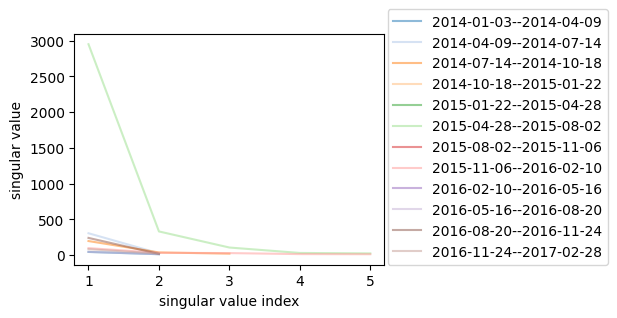

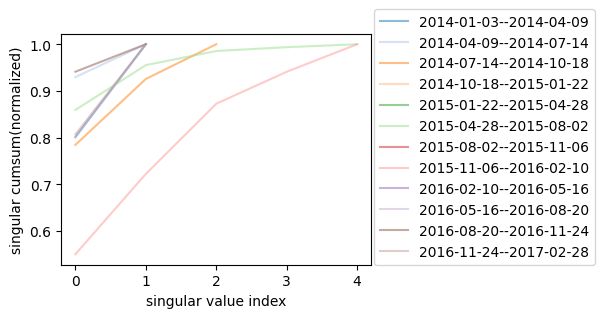

In [5]:
test_id = 'long_term_forecast_cov_qbo_daily_seqlen40_iTransformer_cov_QBO_ft-1_sl40_pl40_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.001_dtTrue_Exp_'
start = 12746
end = 13898
interval = 96
seq_len = 40
gn_1516, entropy_dic, singular, us_1516, vts, mats, Sigs = plot_singular_cum(test_id, eps=10, seed = 0, start=start, end=end, interval=interval, seq_len=seq_len, log_bool=False)
print(gn_1516)

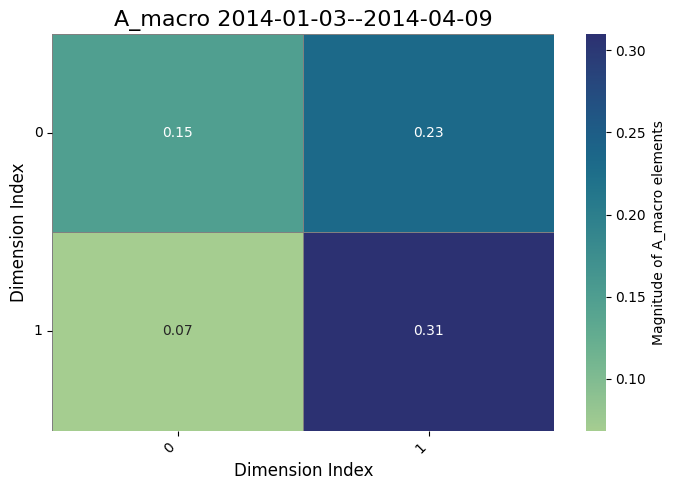

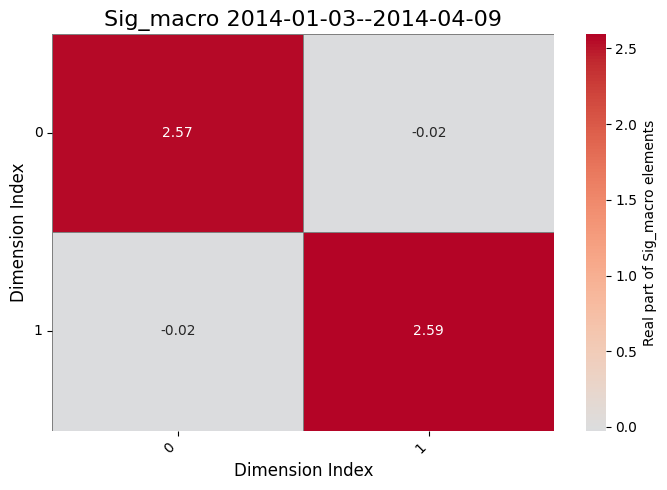

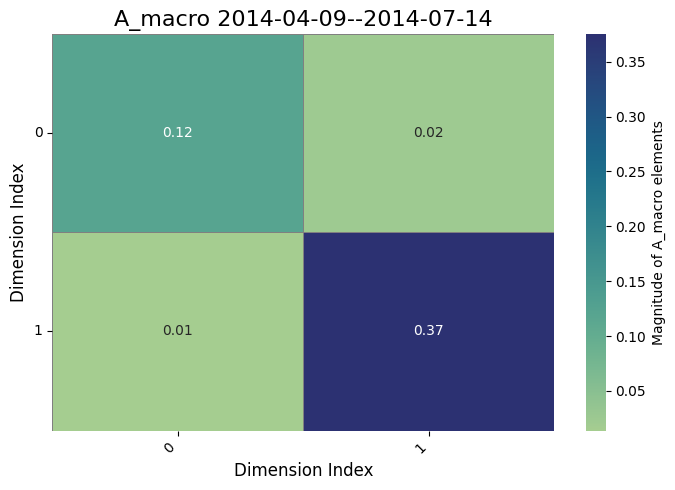

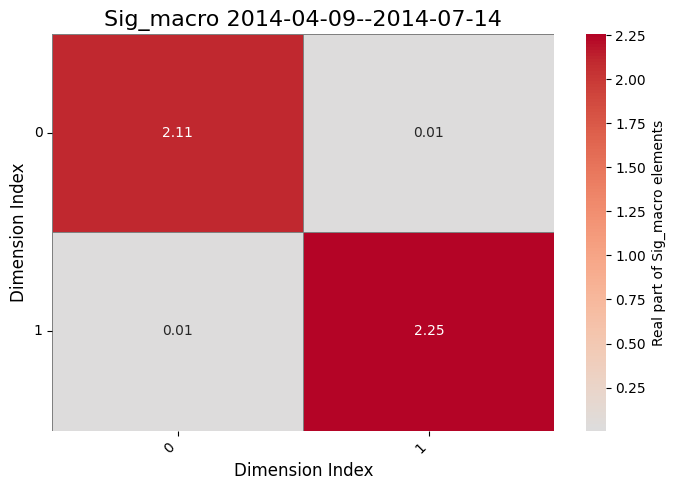

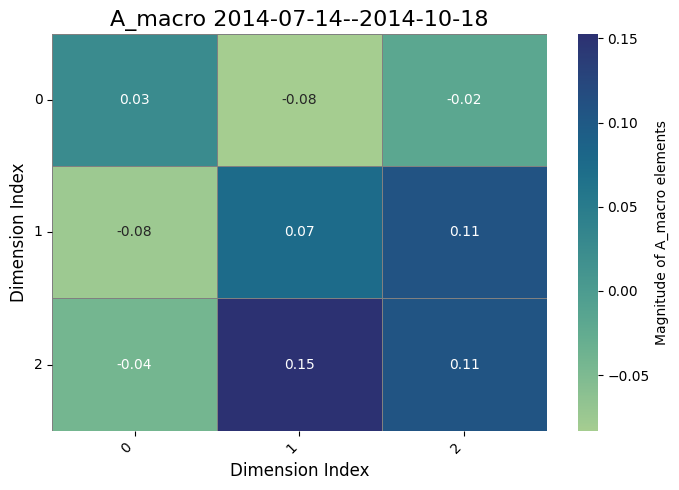

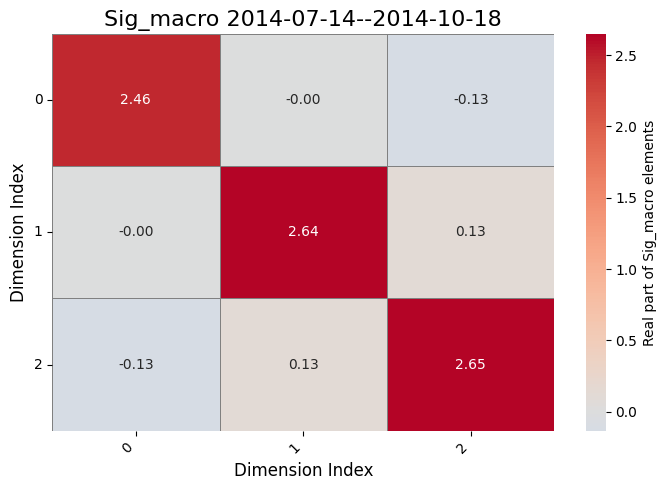

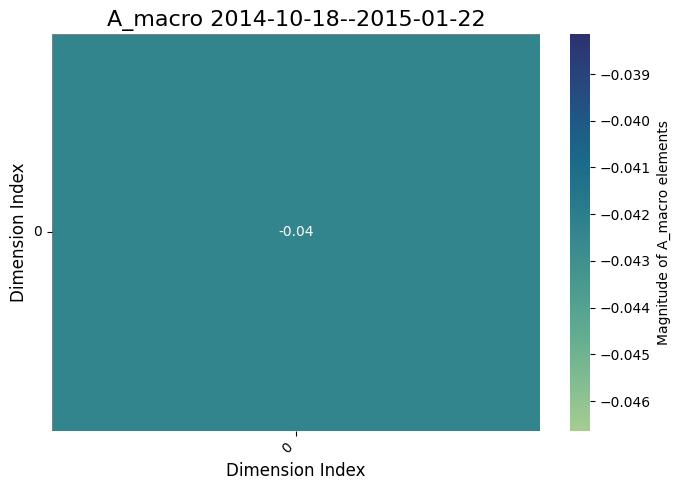

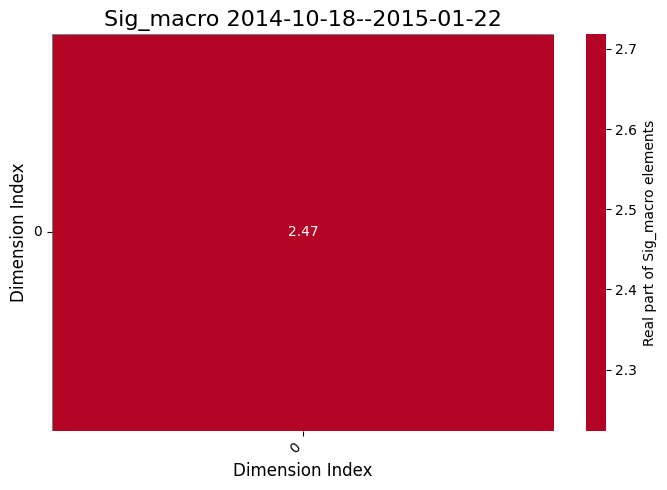

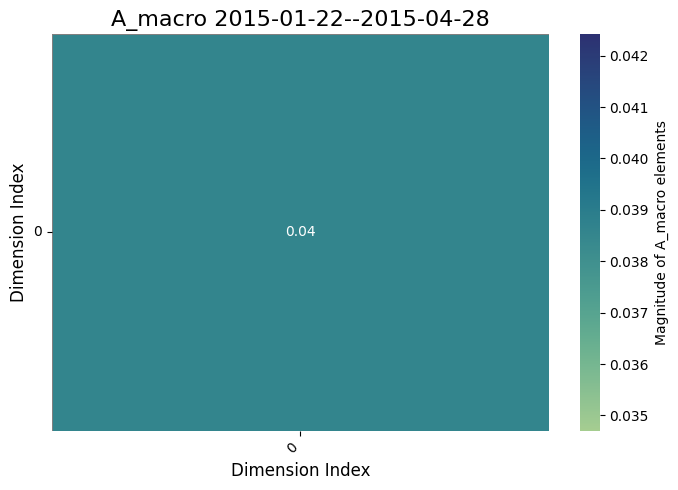

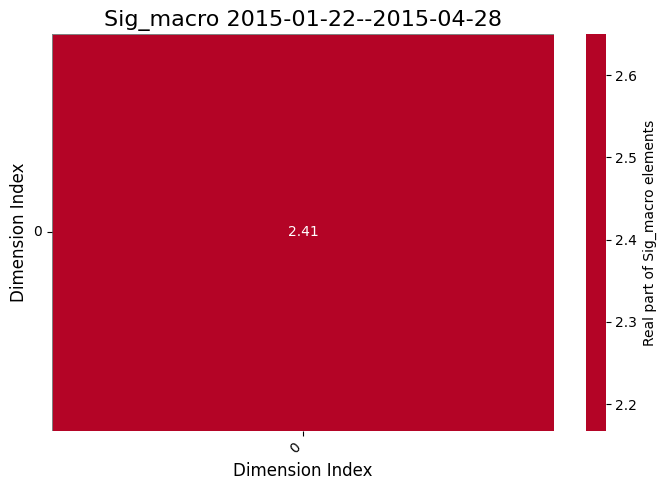

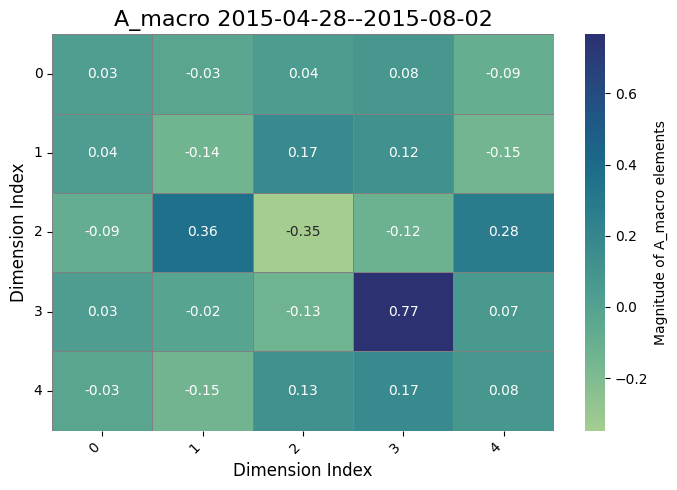

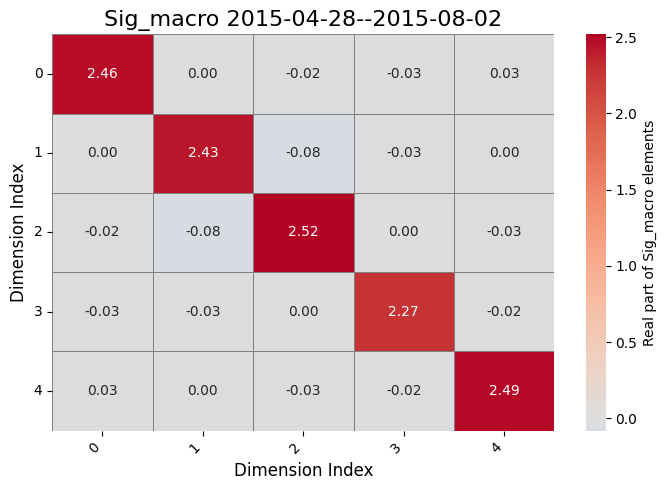

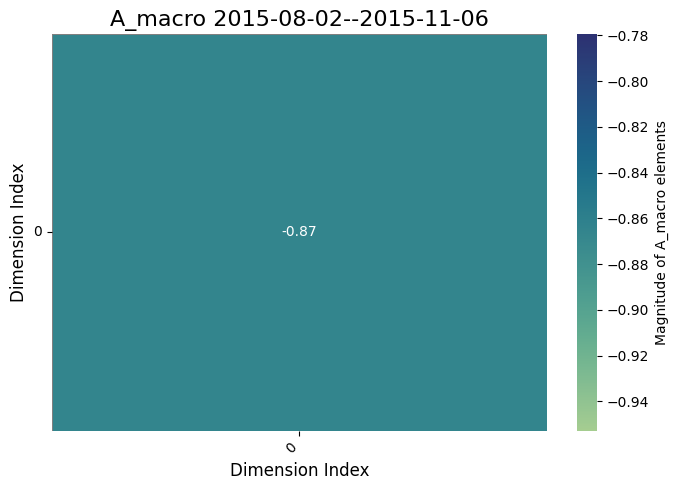

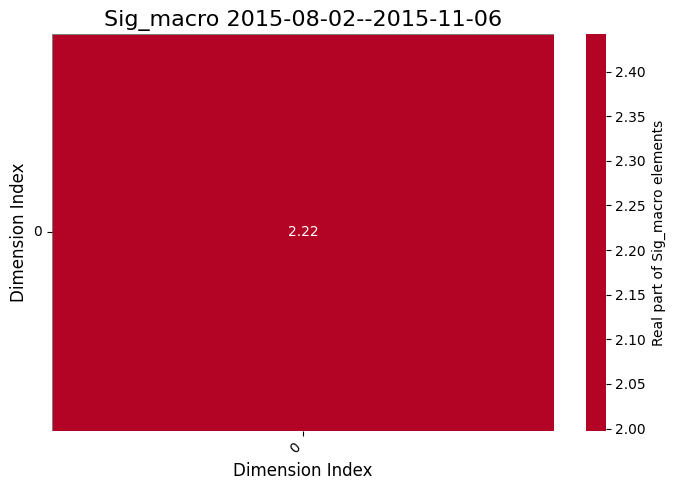

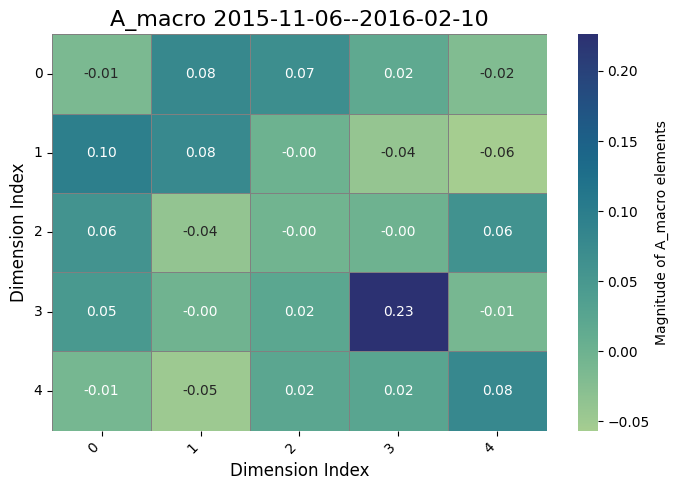

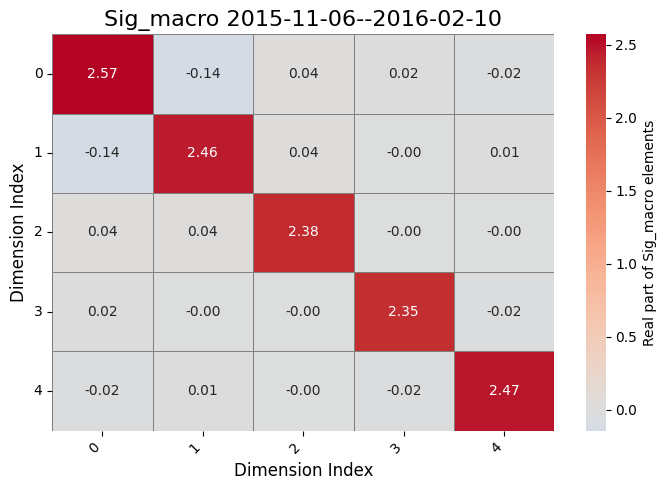

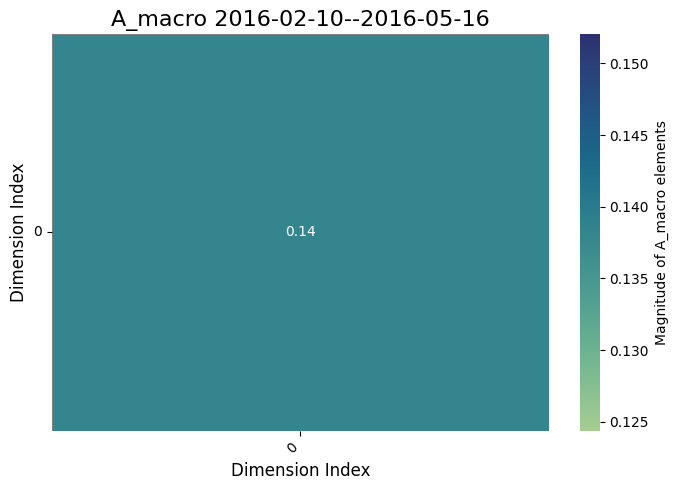

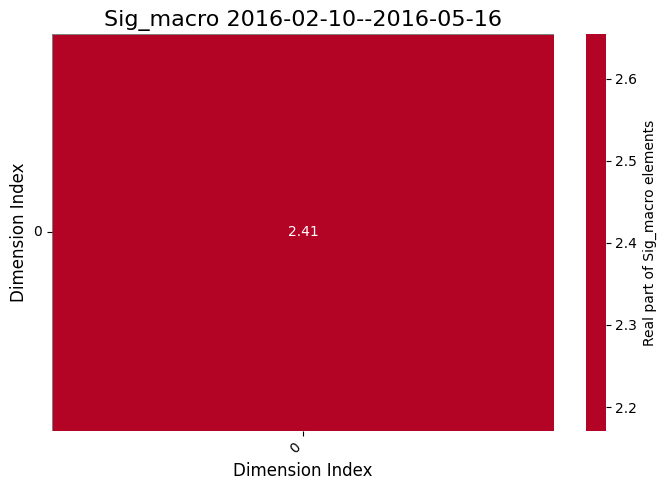

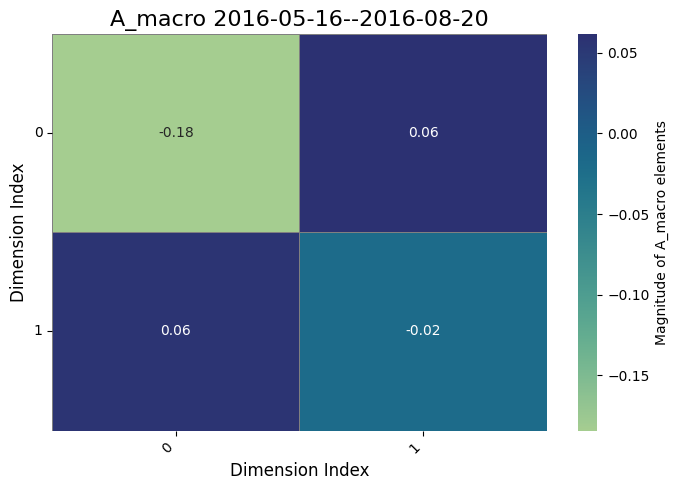

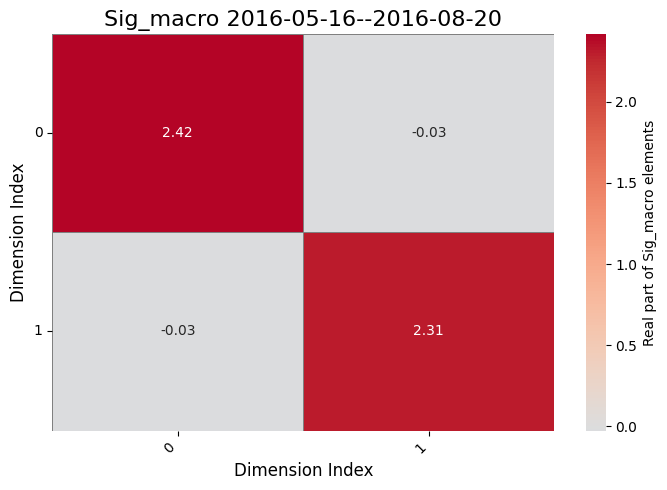

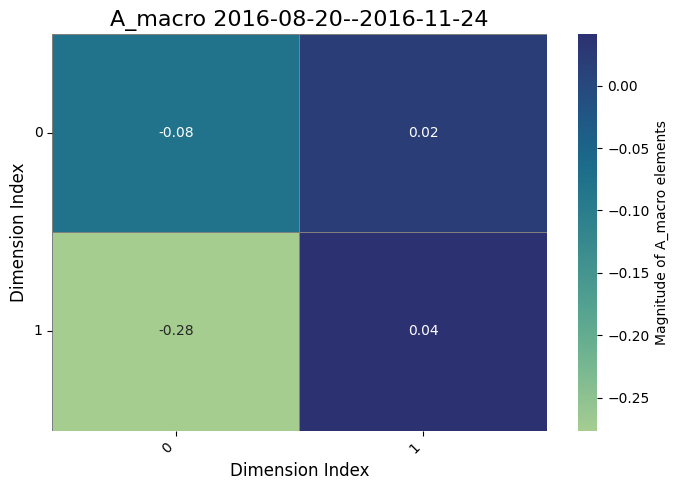

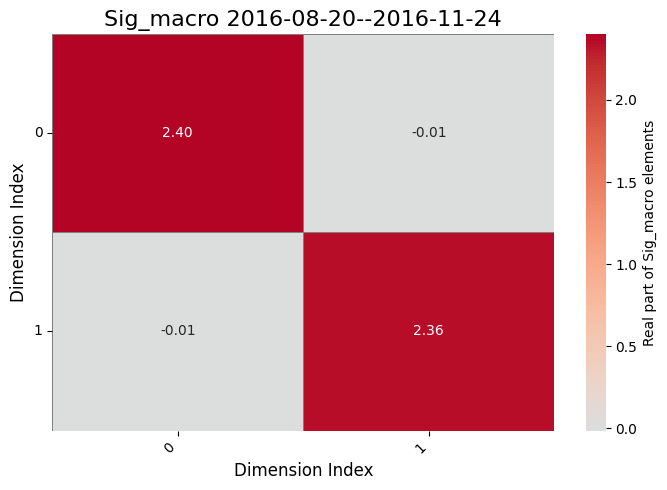

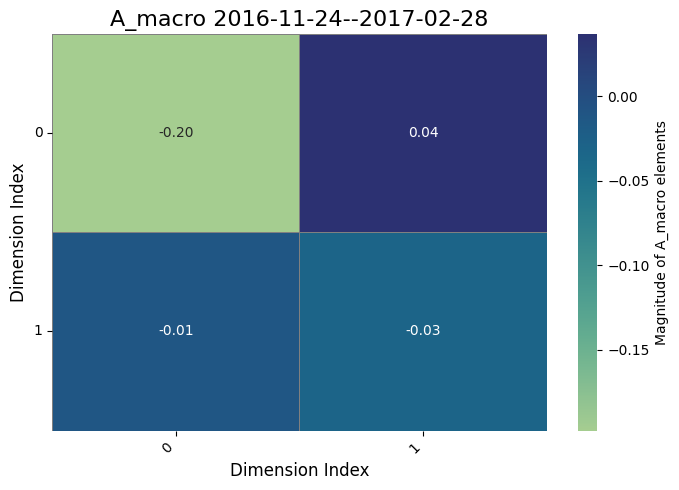

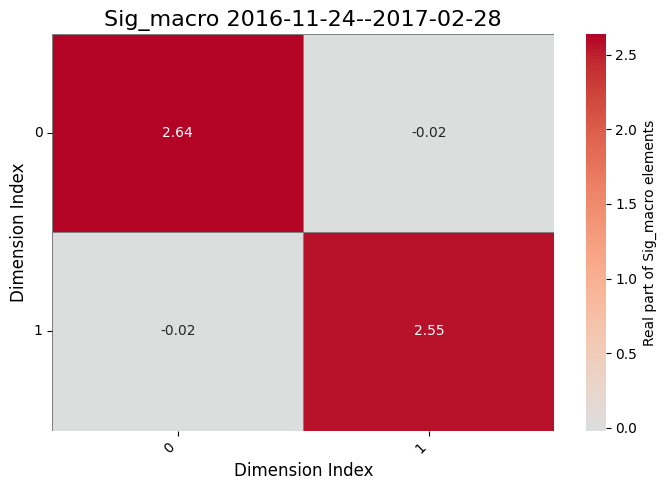

In [10]:
start_date = pd.to_datetime("1979/01/01", format="%Y/%m/%d")
for i in range(start, end, interval):
    time_start = start_date + pd.Timedelta(days=i+seq_len)
    time_end = time_start + pd.Timedelta(days=interval)
    time_str = time_start.strftime("%Y-%m-%d") + '--' + time_end.strftime("%Y-%m-%d")
    A_macro = us_1516[i][0].T @ mats[i][0] @  us_1516[i][0] 
    Sig_macro = us_1516[i][0].T @ Sigs[i][0] @  us_1516[i][0] 
    A_macro = np.real(A_macro)
    Sig_macro = np.real(Sig_macro)
    plt.figure(figsize=(7, 5)) # Adjust figure size as needed
    # Using 'crest' colormap (perceptually uniform, sequential)
    sns.heatmap(A_macro,
                annot=True,             # Show values in cells
                fmt=".2f",              # Format annotations to 2 decimal places
                cmap="crest",           # Uncommon colormap
                linewidths=.5,          # Add lines between cells
                linecolor='gray',       # Color of the lines
                cbar=True,              # Show color bar
                cbar_kws={'label': 'Magnitude of A_macro elements'}) # Label for color bar
    plt.title(f"A_macro "+time_str, fontsize=16)
    plt.xlabel("Dimension Index", fontsize=12)
    plt.ylabel("Dimension Index", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

    # --- Plotting Sig_macro ---
    plt.figure(figsize=(7, 5))
    sns.heatmap(Sig_macro,
                annot=True,
                fmt=".2f", # Or ".2e" if scales vary widely
                cmap="coolwarm",       # Another diverging colormap option
                center=0,
                linewidths=.5,
                linecolor='gray',
                cbar=True,
                cbar_kws={'label': 'Real part of Sig_macro elements'}) # Updated cbar label
    plt.title(f"Sig_macro "+time_str, fontsize=16) # Updated title
    plt.xlabel("Dimension Index", fontsize=12)
    plt.ylabel("Dimension Index", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

# Best results

{'2014-01-03--2014-04-09': 0.1798377740623911, '2014-04-09--2014-07-14': 0.25935993458545403, '2014-07-14--2014-10-18': 0.2398518858125368, '2014-10-18--2015-01-22': 0.1629876630281708, '2015-01-22--2015-04-28': 0.16713872618583825, '2015-04-28--2015-08-02': 0.4339863543180751, '2015-08-02--2015-11-06': 0.18248419098809554, '2015-11-06--2016-02-10': 0.2241968227502501, '2016-02-10--2016-05-16': 0.17014706436988414, '2016-05-16--2016-08-20': 0.17875898587409256, '2016-08-20--2016-11-24': 0.24143627912807697, '2016-11-24--2017-02-28': 0.1959357841192606}


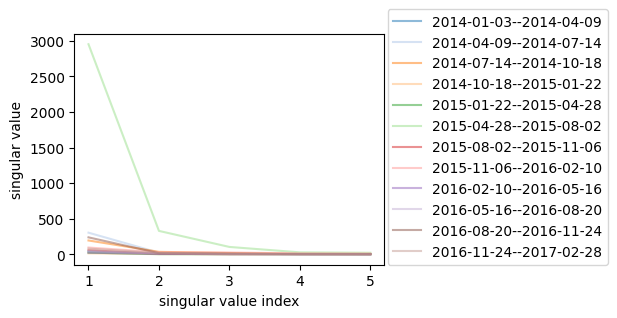

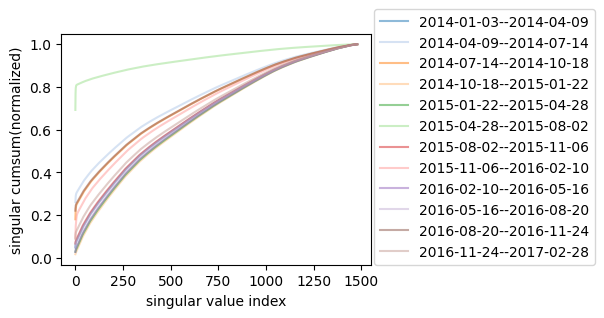

In [2]:
test_id = 'long_term_forecast_cov_qbo_daily_seqlen40_iTransformer_cov_QBO_ft-1_sl40_pl40_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.001_dtTrue_Exp_'
start = 12746
end = 13898
interval = 96
seq_len = 40
gn_1516, entropy_dic, singular, us_1516, vts = plot_singular_cum(test_id, m='all', seed = 0, start=start, end=end, interval=interval, seq_len=seq_len, sigmas=True, log_bool=False)
print(gn_1516)

{'2017-06-04--2017-09-08': 0.46231794738307075, '2017-09-08--2017-12-13': 0.368691477739002, '2017-12-13--2018-03-19': 0.2508081906278369, '2018-03-19--2018-06-23': 0.20031740622595062, '2018-06-23--2018-09-27': 0.1762985002152171, '2018-09-27--2019-01-01': 0.26648920111942276, '2019-01-01--2019-04-07': 0.20055706118072392, '2019-04-07--2019-07-12': 0.2302582360542248, '2019-07-12--2019-10-16': 0.4913946879462878, '2019-10-16--2020-01-20': 0.16978959582040454, '2020-01-20--2020-04-25': 0.22864617271478715, '2020-04-25--2020-07-30': 0.15889803492022925, '2020-07-30--2020-11-03': 0.20357328281060205, '2020-11-03--2021-02-07': 0.1896925845308879}


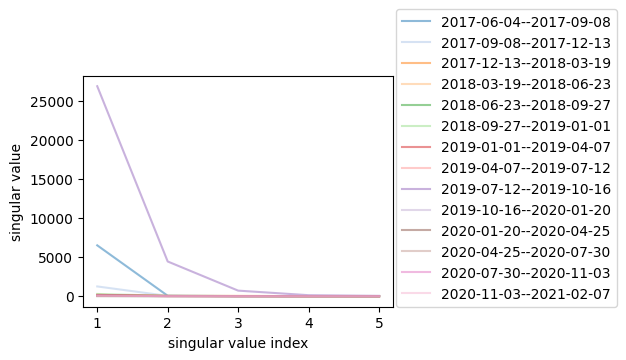

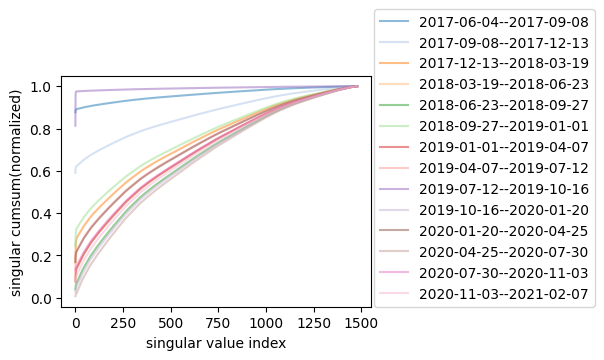

In [4]:
test_id = 'long_term_forecast_cov_qbo_daily_seqlen40_iTransformer_cov_QBO_ft-1_sl40_pl40_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.001_dtTrue_Exp_'
start = 13994
end = 15338
gn_1920, entropy_dic, singular, us_1920, vts = plot_singular_cum(test_id, m='all', seed = 0, start=start, end=end, interval=interval, seq_len=seq_len, sigmas=True, log_bool=False)
print(gn_1920)

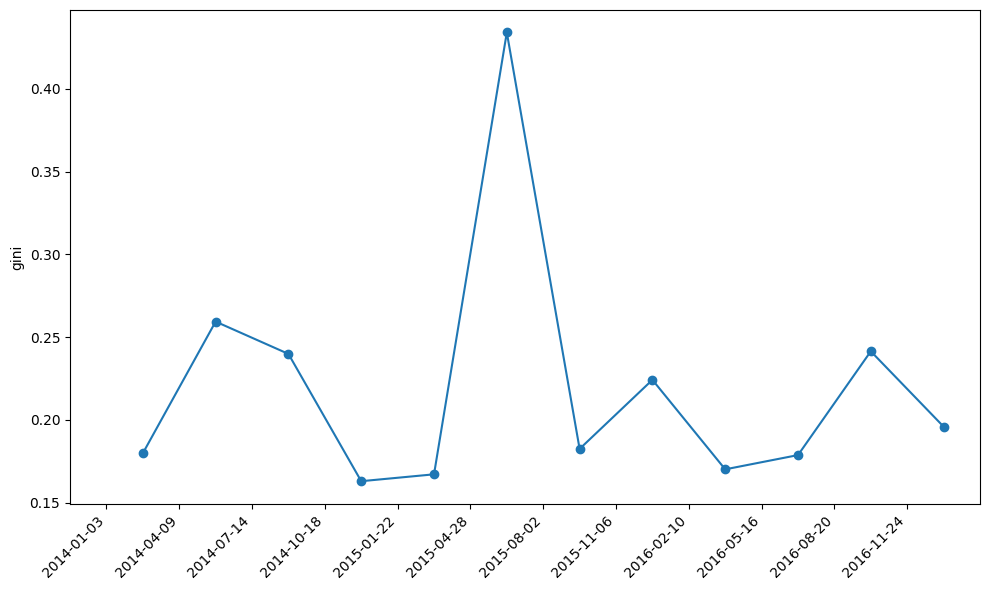

In [3]:
x_labels0 = list(gn_1516.keys())
x_labels = [i[:10] for i in x_labels0]
y_values = list(gn_1516.values())
tick_positions = np.arange(len(x_labels))
marker_x_positions = tick_positions + 0.5

plt.figure(figsize=(10, 6))
plt.plot(marker_x_positions, y_values, marker='o', linestyle='-')
plt.ylabel("gini")
plt.xticks(ticks=tick_positions, labels=x_labels, rotation=45, ha='right')
if len(marker_x_positions) > 0:
    plt.xlim(tick_positions[0] - 0.5, tick_positions[-1] + 0.5 + 0.5)
plt.tight_layout()
plt.show()

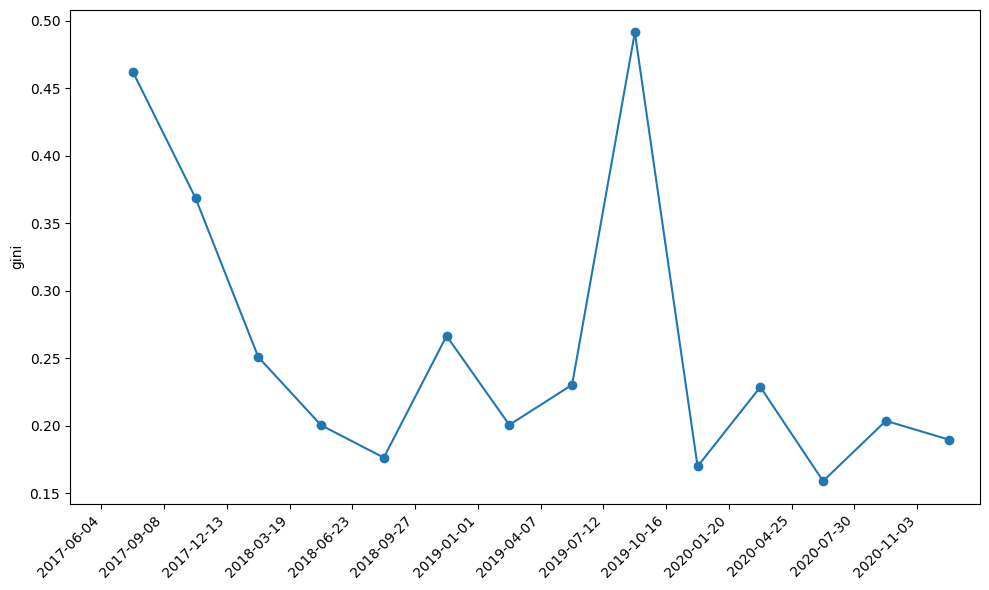

In [5]:
x_labels0 = list(gn_1920.keys())
x_labels = [i[:10] for i in x_labels0]
y_values = list(gn_1920.values())
tick_positions = np.arange(len(x_labels))
marker_x_positions = tick_positions + 0.5

plt.figure(figsize=(10, 6))
plt.plot(marker_x_positions, y_values, marker='o', linestyle='-')
plt.ylabel("gini")
plt.xticks(ticks=tick_positions, labels=x_labels, rotation=45, ha='right')
if len(marker_x_positions) > 0:
    plt.xlim(tick_positions[0] - 0.5, tick_positions[-1] + 0.5 + 0.5)
plt.tight_layout()
plt.show()

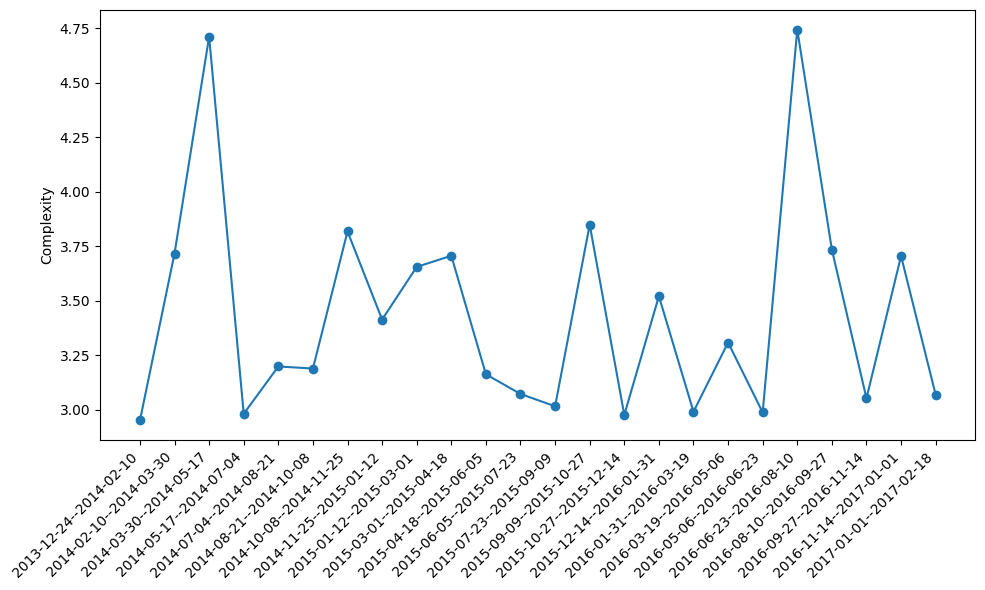

In [26]:
x_labels = list(entropy_dic.keys())
y_values = list(entropy_dic.values())
plt.figure(figsize=(10, 6))
plt.plot(x_labels, y_values, marker='o')
plt.ylabel("Complexity")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipykernel_19738/3794022489.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,4),dpi=150)


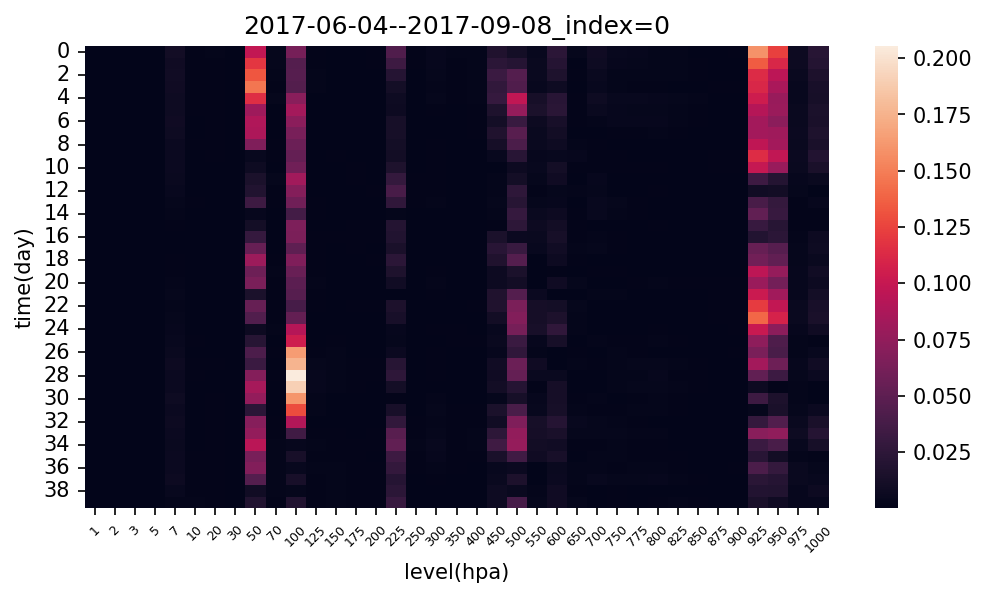

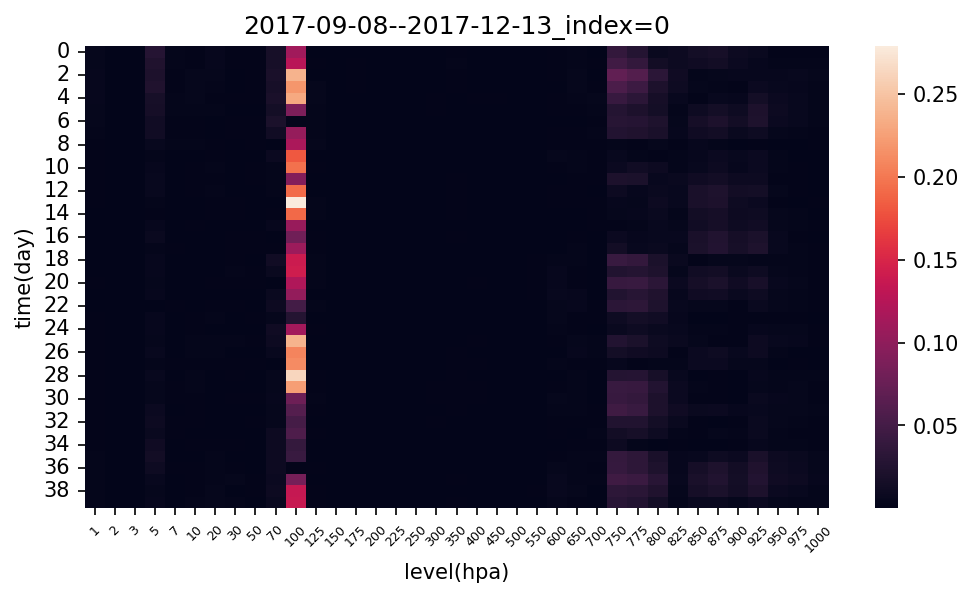

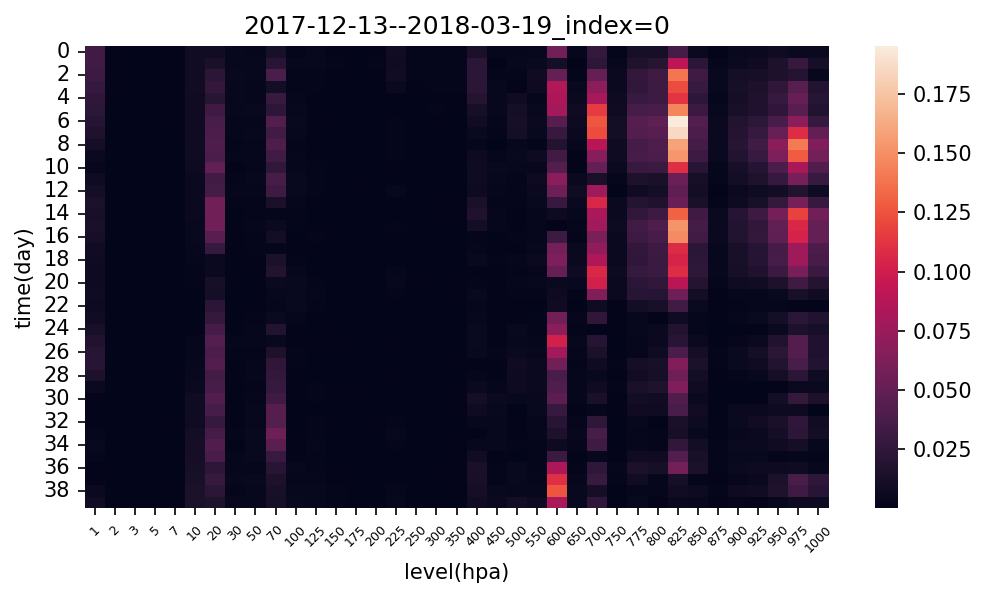

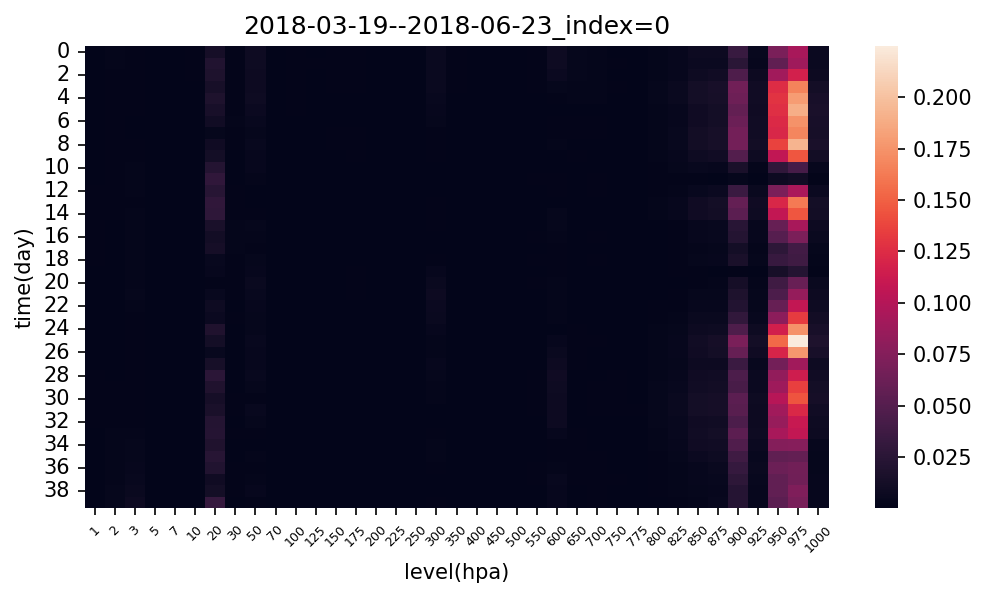

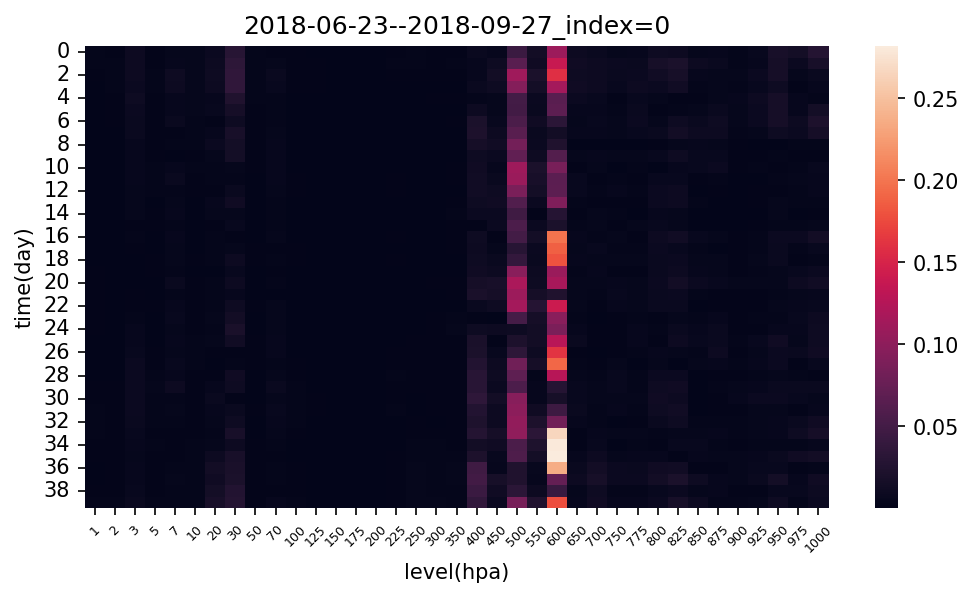

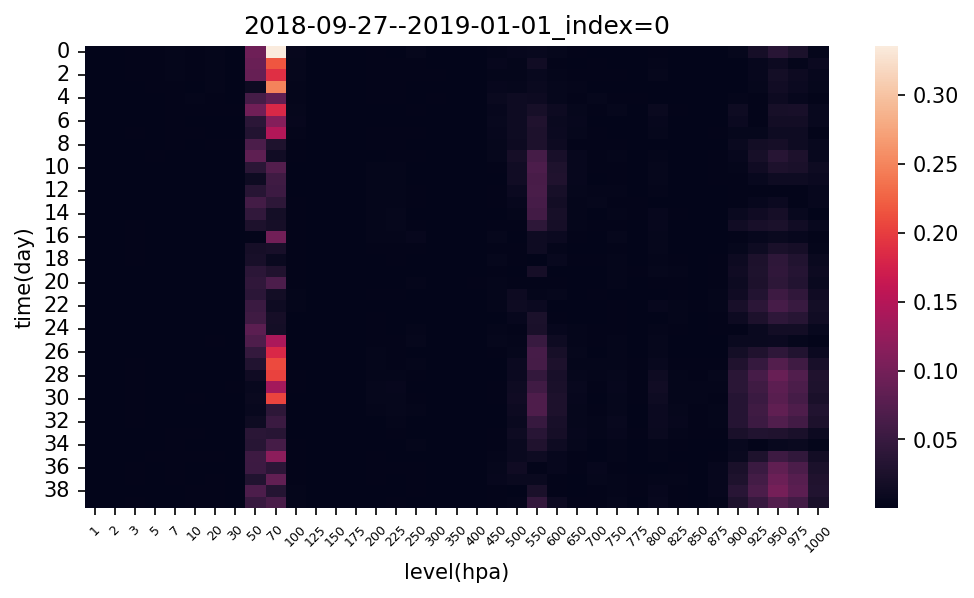

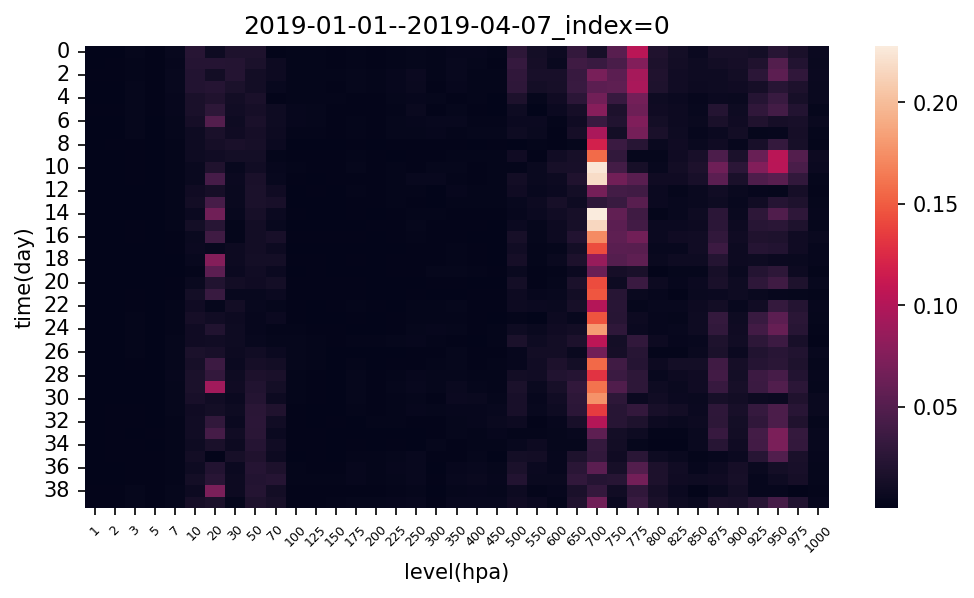

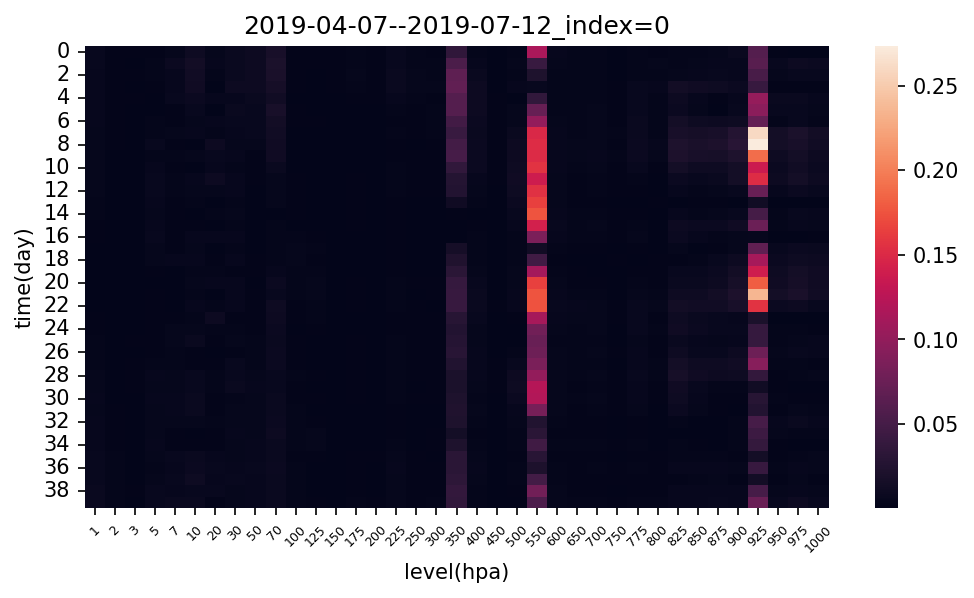

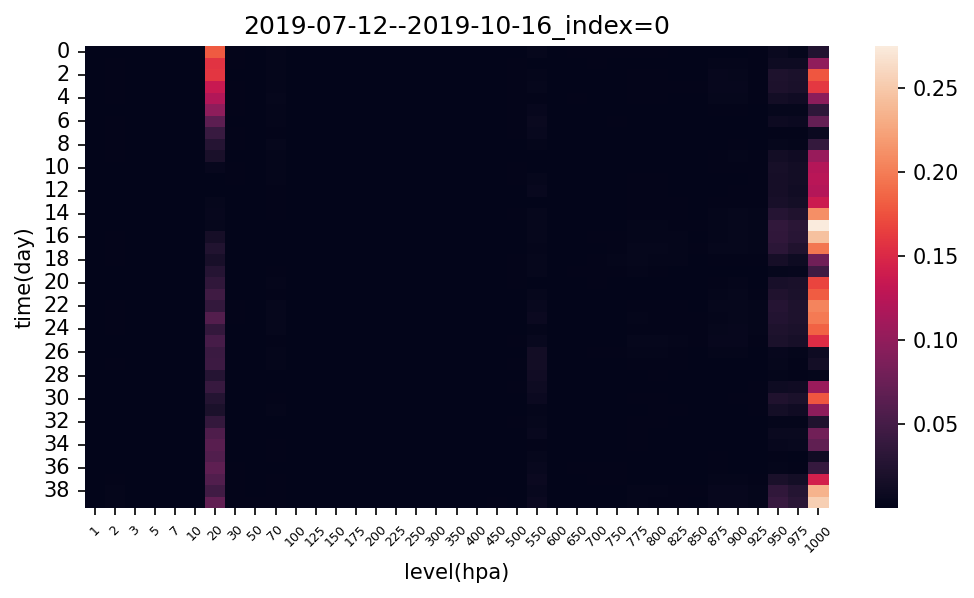

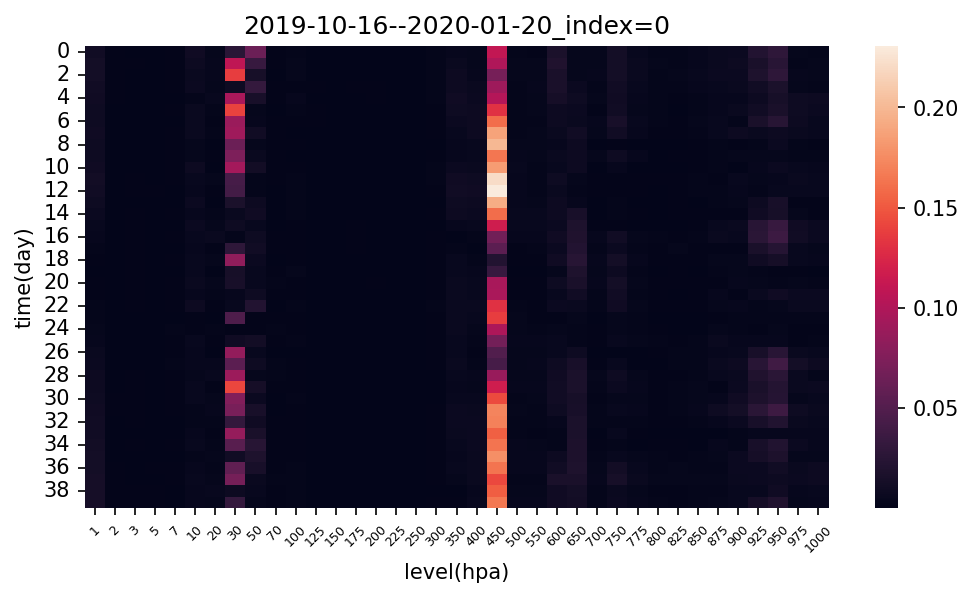

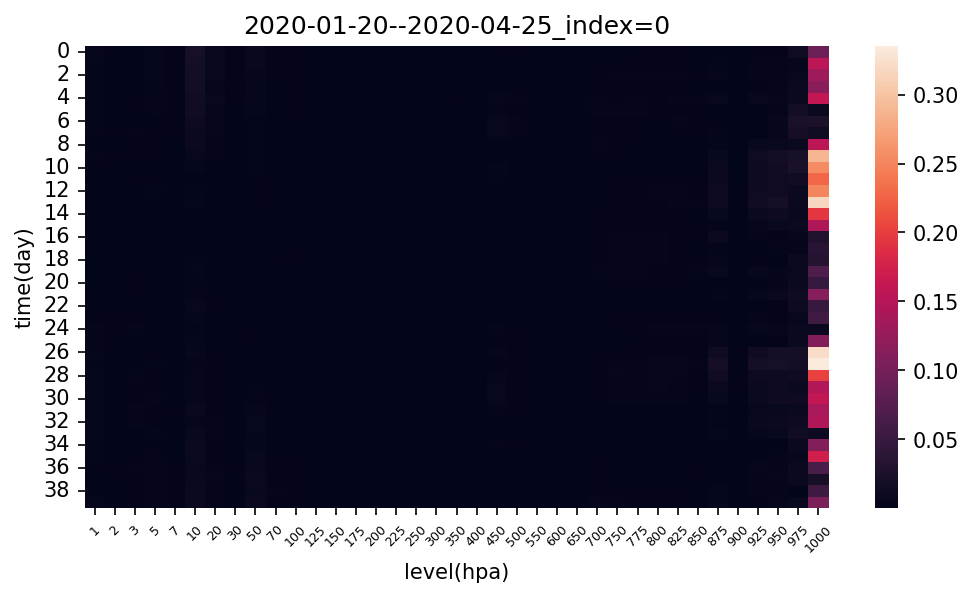

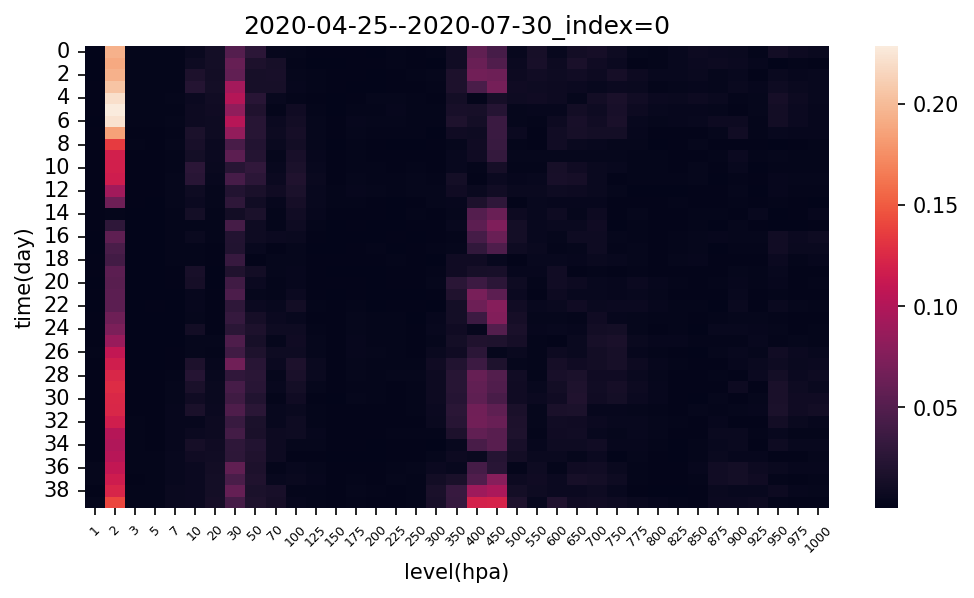

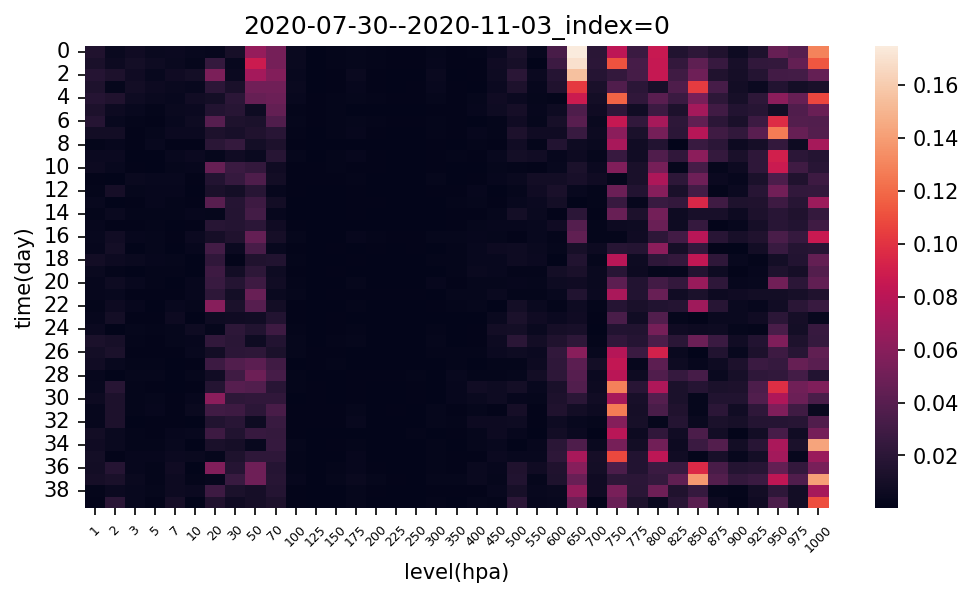

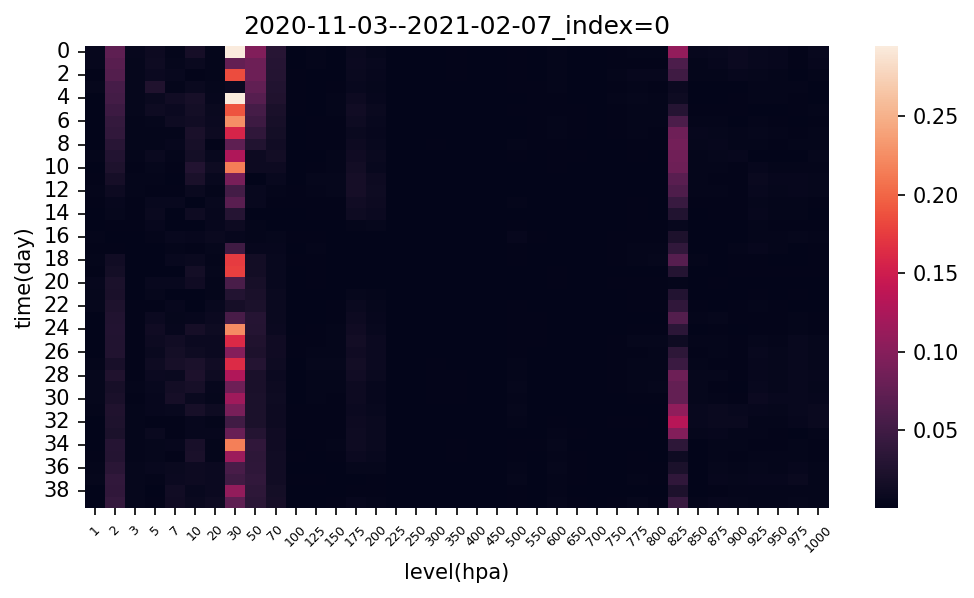

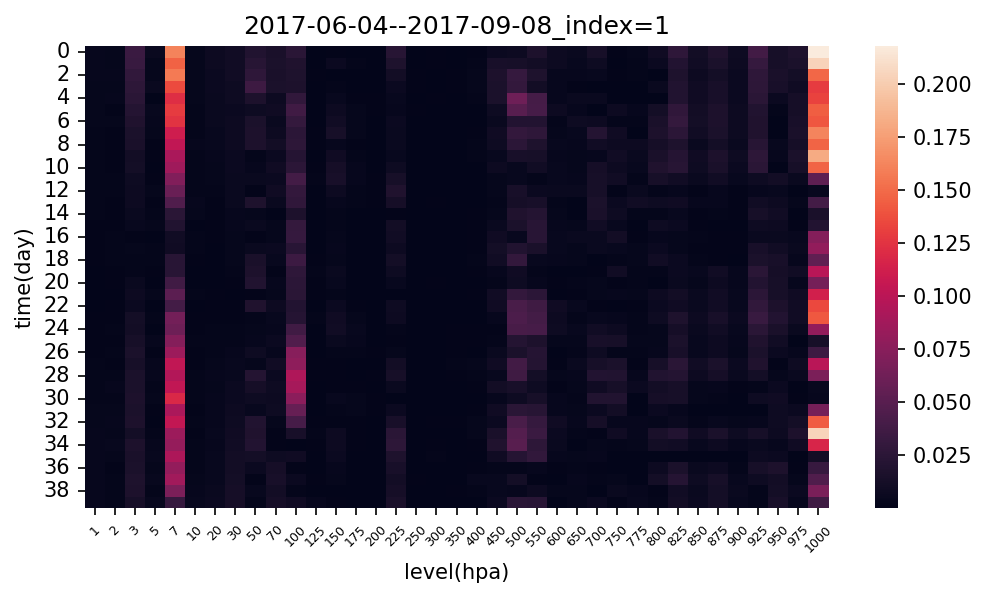

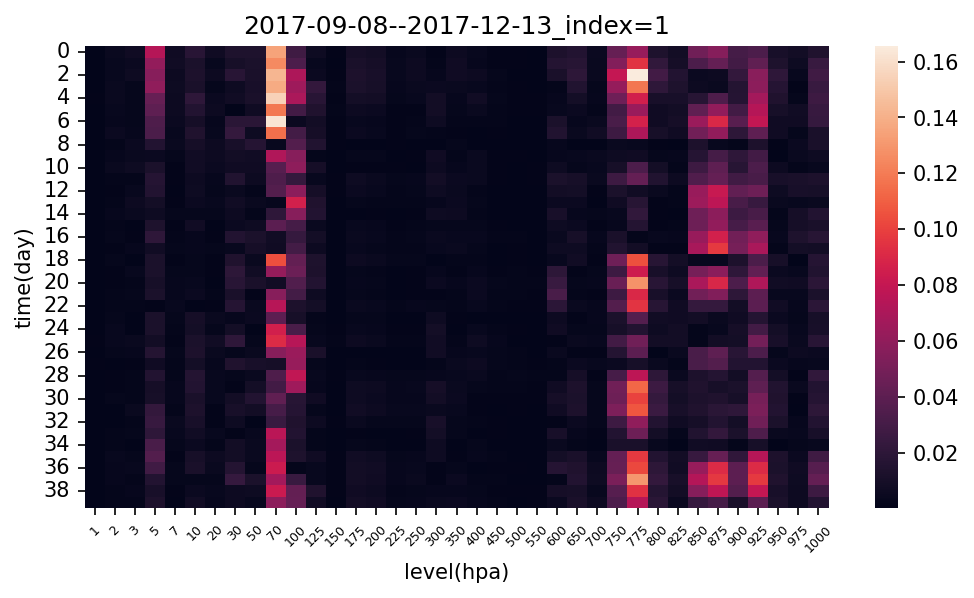

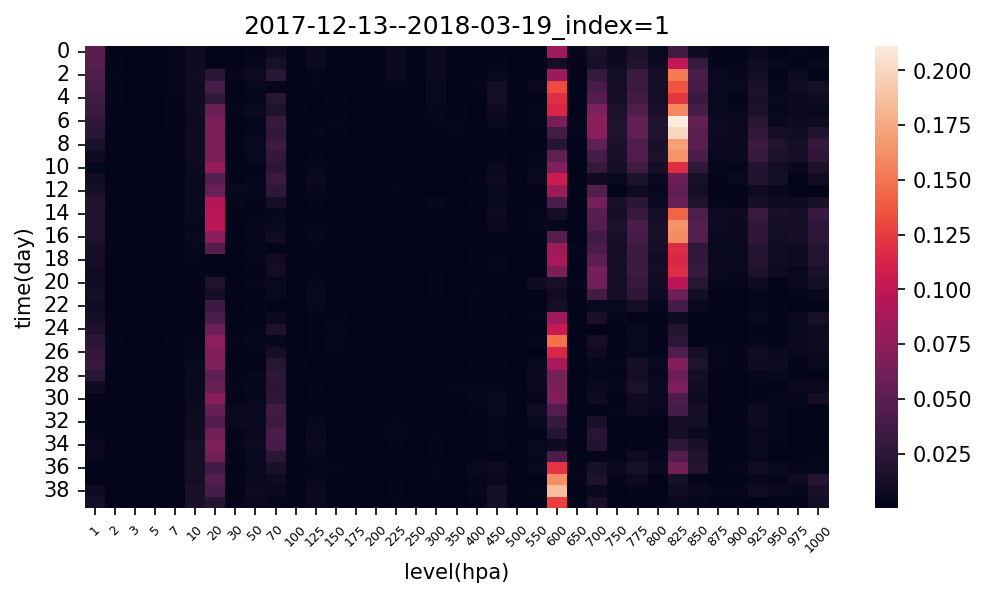

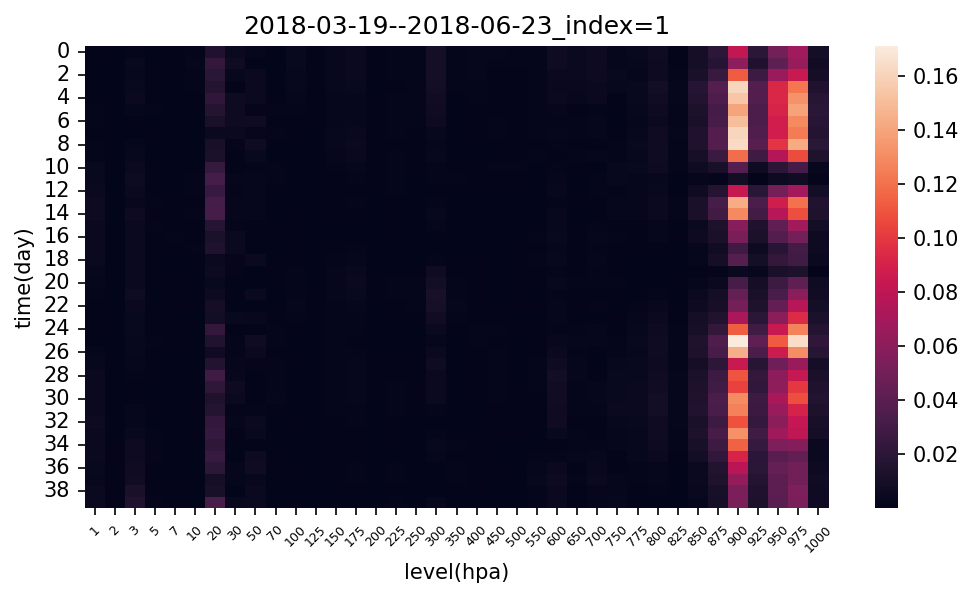

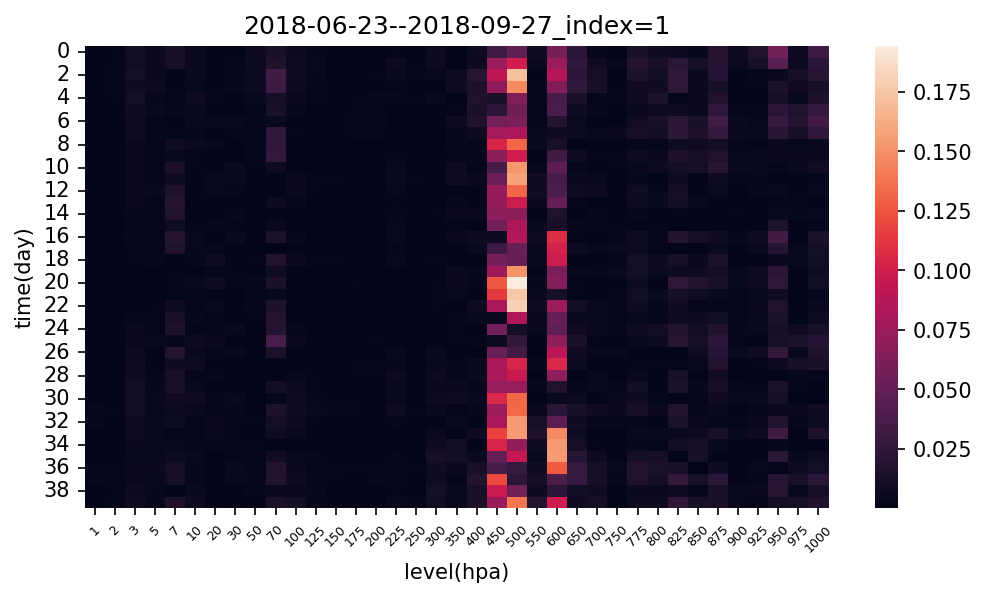

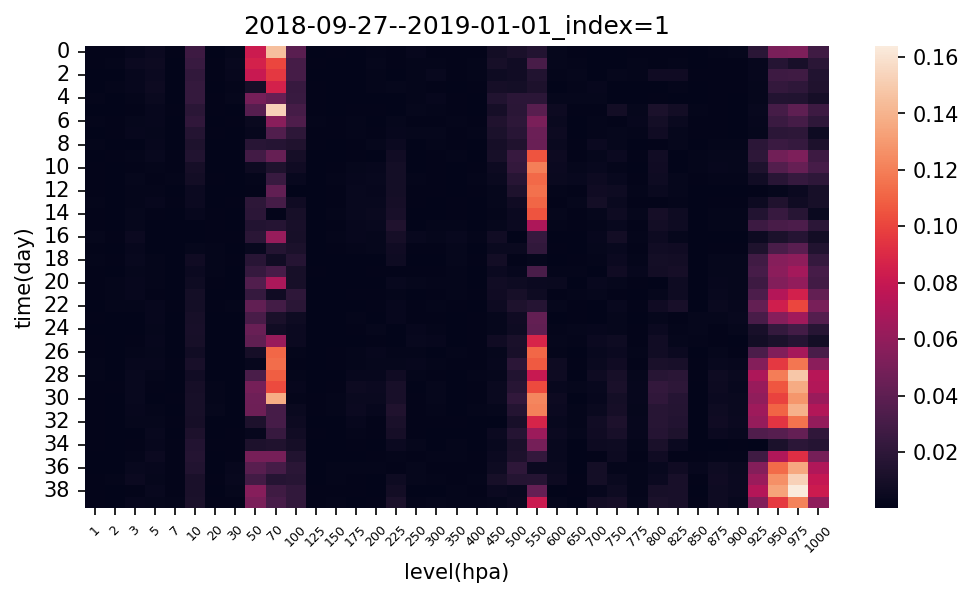

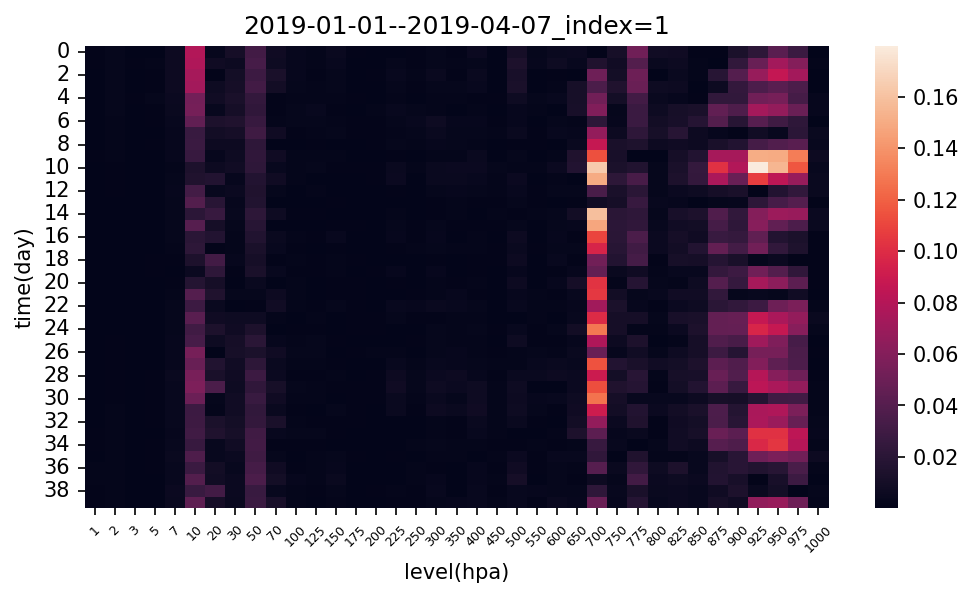

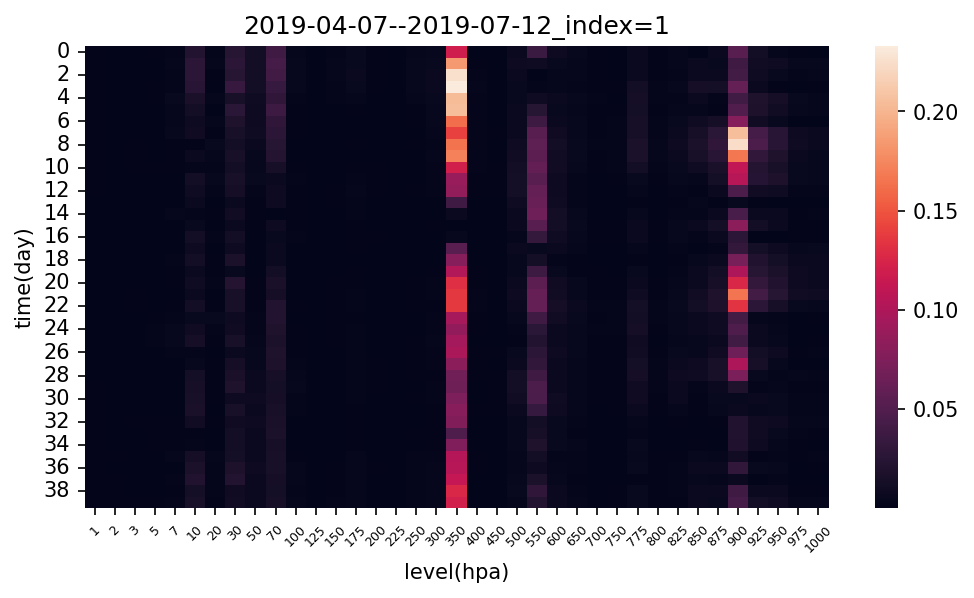

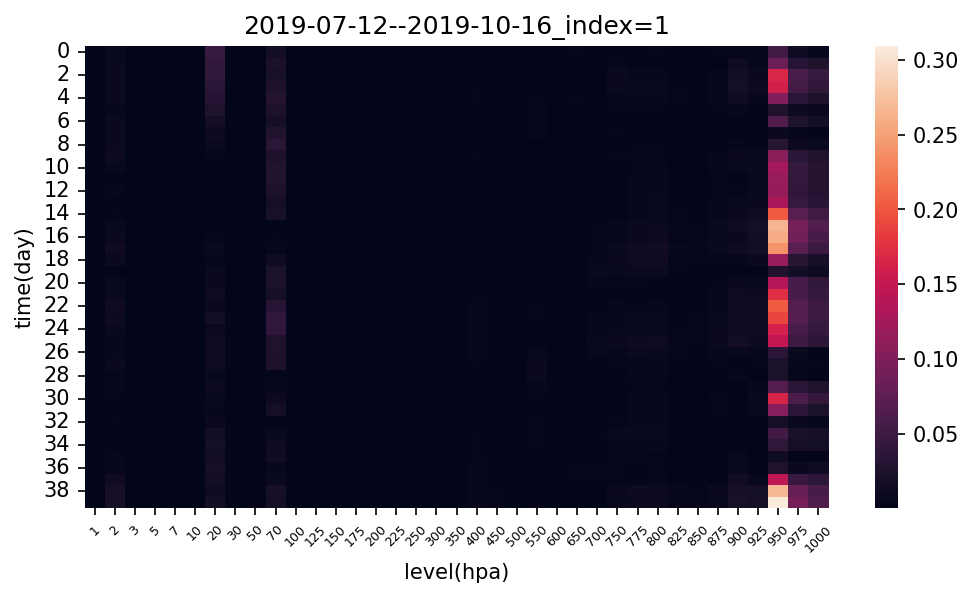

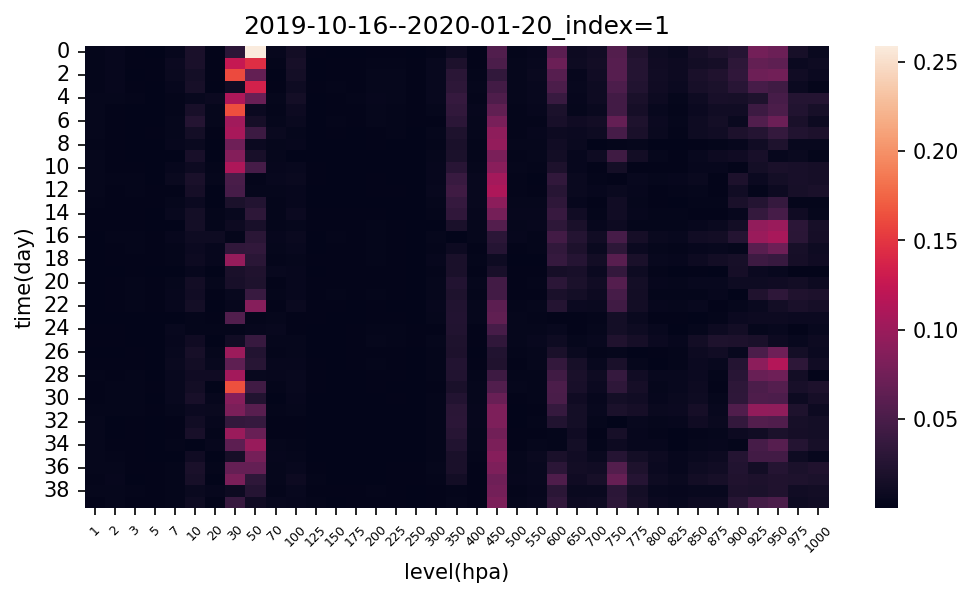

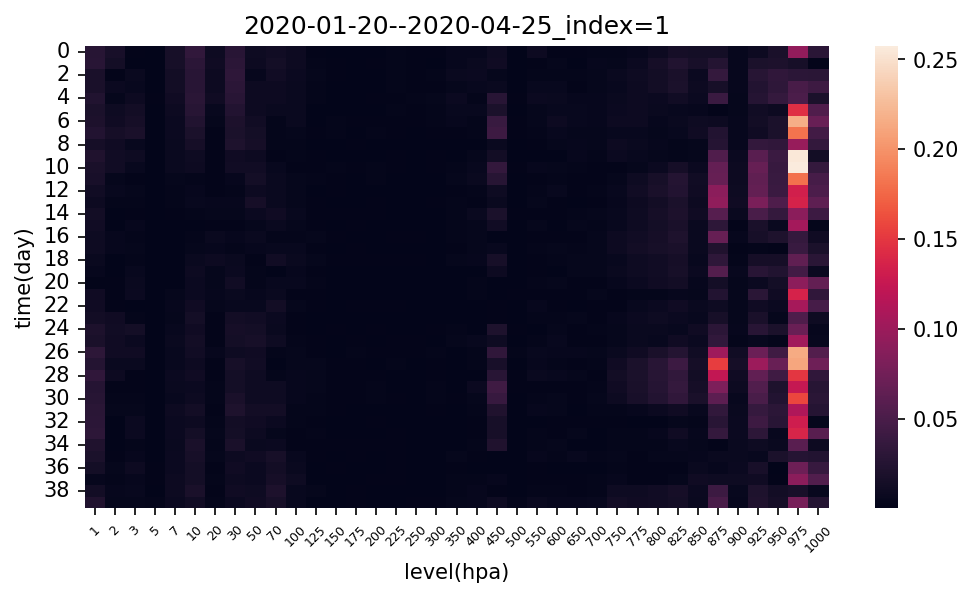

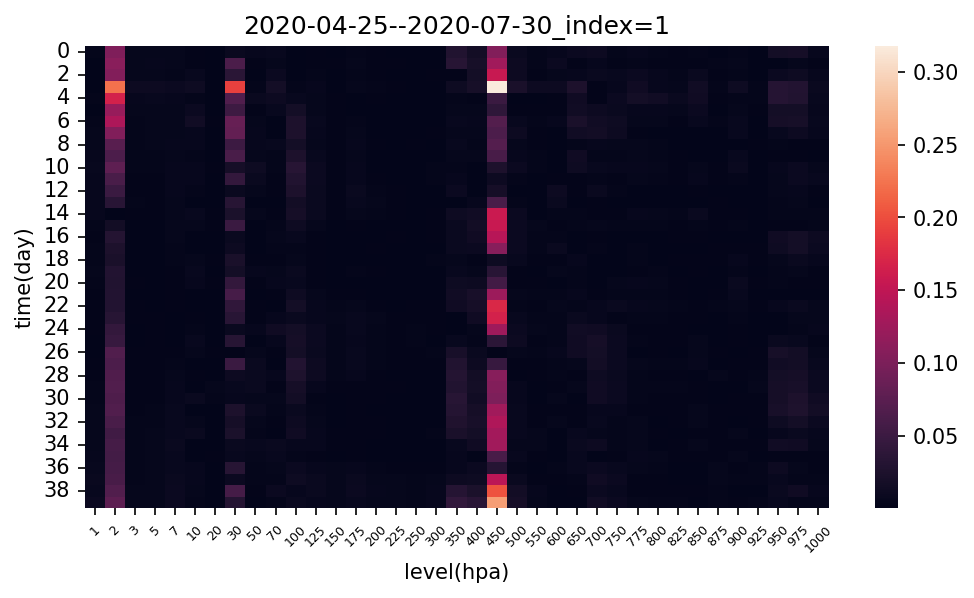

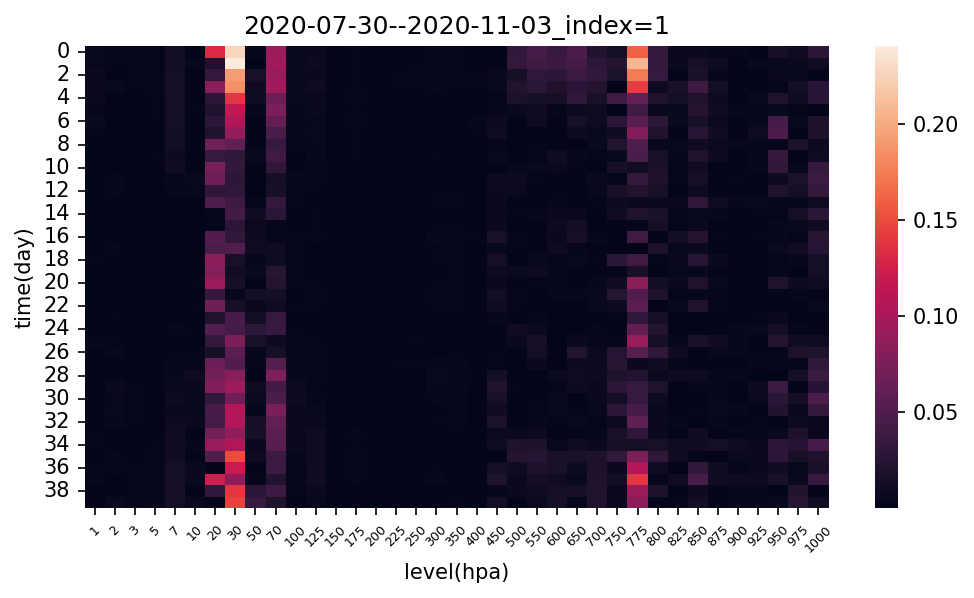

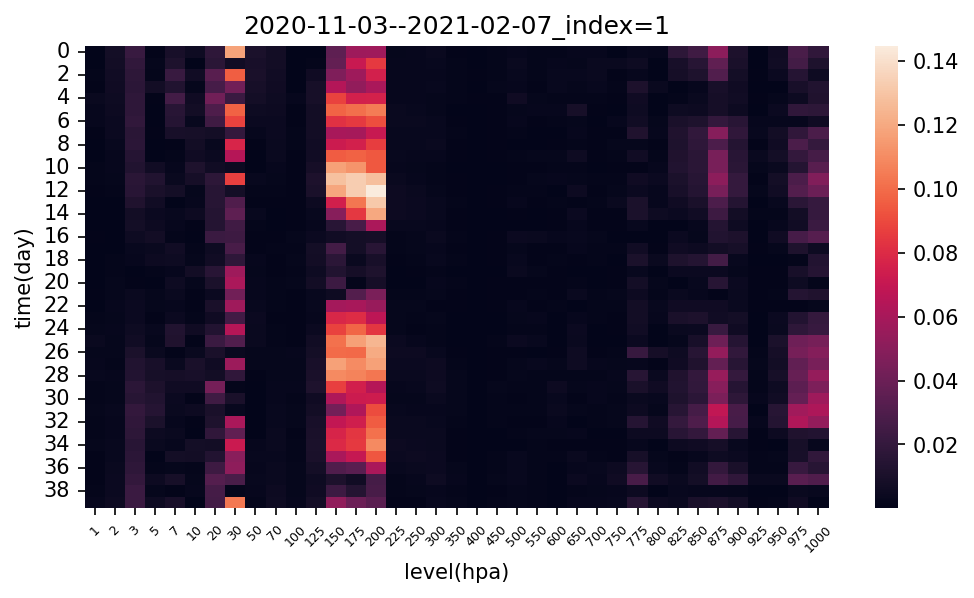

In [35]:
analysis_u(us_1920, seq_len=40, dims=37, start=start, end=end, interval=interval, target=[0,1])

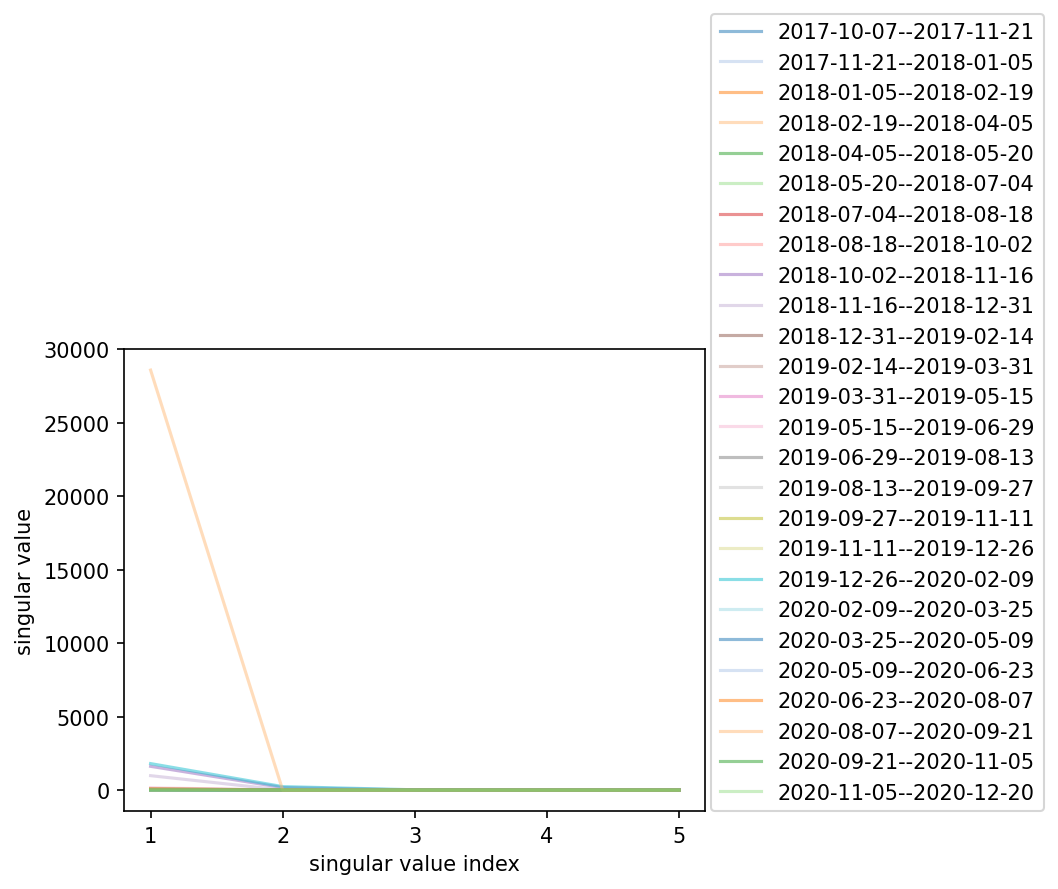

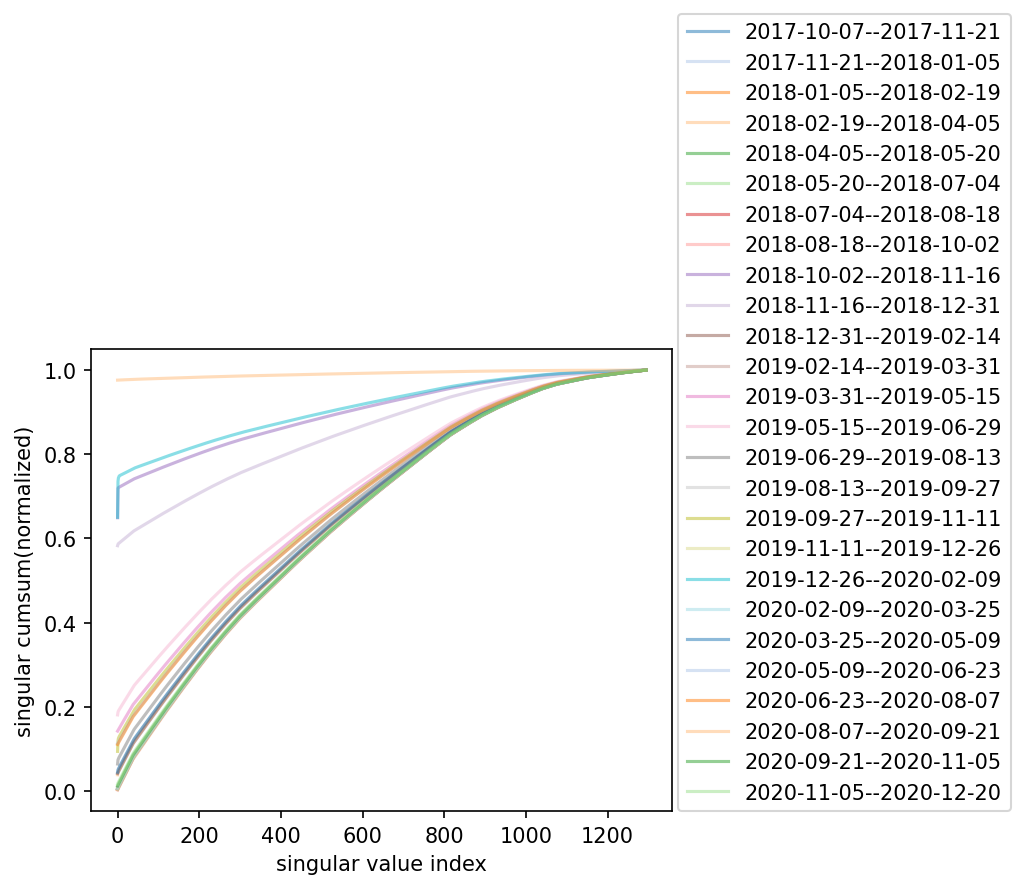

In [13]:
start = 14129
end = 15299
gn_dic, singular, us, vts = plot_singular_cum(test_id, m='all', seed = 0, start=start, end=end, interval=interval, sigmas=True, log_bool=False)

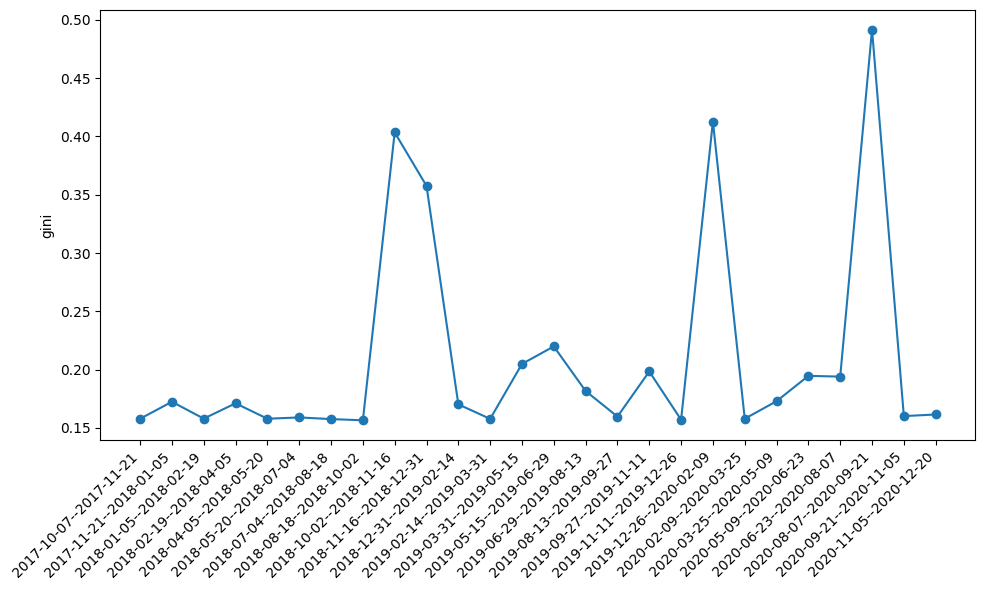

In [14]:
# 提取 key 与 value
x_labels = list(gn_dic.keys())
y_values = list(gn_dic.values())

# 创建折线图
plt.figure(figsize=(10, 6))
plt.plot(x_labels, y_values, marker='o')

# 设置坐标轴和标题
# plt.xlabel("Category")
plt.ylabel("gini")
# plt.title("Line Chart for Dict Data")

# 旋转 x 轴标签，防止重叠
plt.xticks(rotation=45, ha='right')

# 可选：调整布局防止标签被截断
plt.tight_layout()

plt.show()

In [ ]:
analysis_u(us, seq_len=35, dims=37, start=start, end=end, interval=interval, target=[0,1])

# 其他结果

{'2013-03-03': 0.4994369389832829,
 '2013-06-07': 0.4994369390915926,
 '2013-09-11': 0.4994369428523261,
 '2013-12-16': 0.49943694141055883,
 '2014-03-22': 0.49943678227321475,
 '2014-06-26': 0.49943694003671923,
 '2014-09-30': 0.4994369484550083,
 '2015-01-04': 0.4994369356534134,
 '2015-04-10': 0.4994369378781157,
 '2015-07-15': 0.4994369383431725,
 '2015-10-19': 0.49943659491027614,
 '2016-01-23': 0.49943544927366534,
 '2016-04-28': 0.49943534159141745,
 '2016-08-02': 0.49943693899980224}

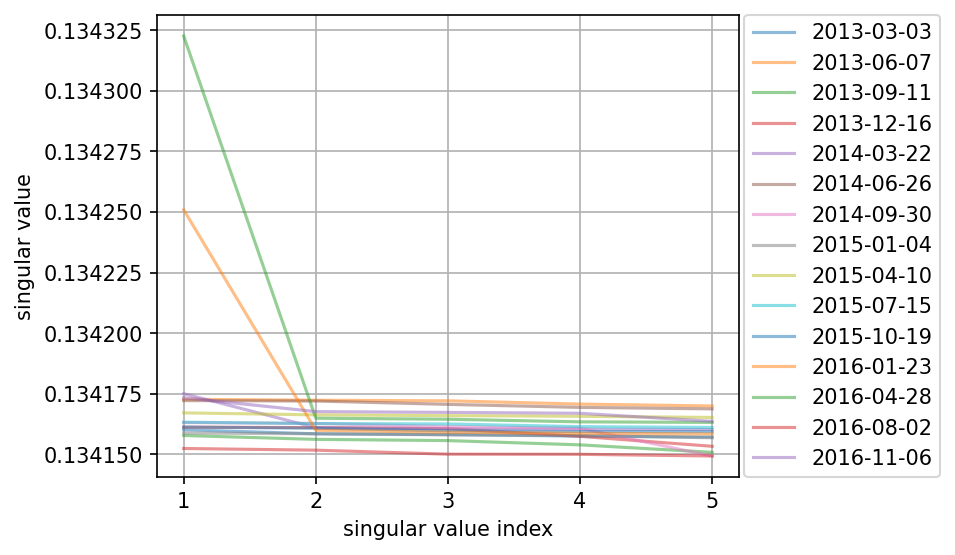

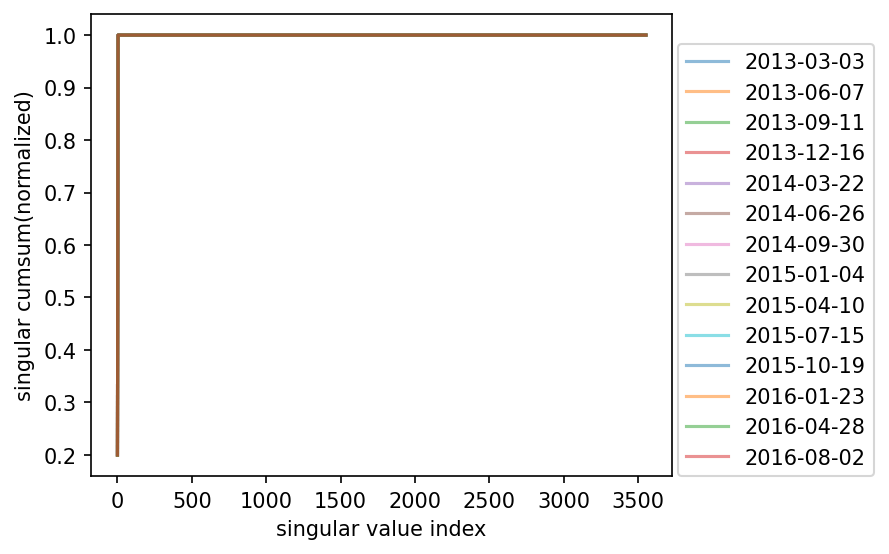

In [24]:
test_id = 'long_term_forecast_iT_cov_qbo_daily_iTransformer_QBO_ft5_sl96_pl96_dm512_nh8_el4_dl1_df512_fc3_flocvali_first_lam0.0_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=96, dims=5, start=12480, end=13824, interval=96, window=5, sigmas=False)
plot_singular_cum(test_id, seeds = 1, length=96, dims=5, start=12480, end=13824, interval=96, window='all', sigmas=False, figure_show=True)

# 对f(x)的Jacobian矩阵做SVD分解

In [2]:
#test_id_first = "long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl1_pl1_dm512_nh8_el4_dl1_df512_fc3_ebtimeF_dtTrue_Exp_"
def plot_singular(test_id_first, seeds = 1, length=1, window=5, sigmas=True):
    jacs = {i:[] for i in range(852, 960, 12)}
    for expid in range(seeds):
        test_id = test_id_first + str(expid)
        for i in range(852, 960, 12):
            str_i = f'{i:04d}'
            mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(length*37, -1).astype(float)
            mat = mat.T @ mat
            if sigmas:
                L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
                mat = mat.T @ inv(L[0]) @ mat
            u, s, vt = np.linalg.svd(mat)
            jacs[i].append(s)

    plt.figure(figsize=(5,4),dpi=150)
    for i in range(852, 960, 12):
        jac_arr = np.array(jacs[i])
        jac_mean = np.mean(jac_arr, axis=0)
        jac_std = np.std(jac_arr, axis=0)


        plt.plot(jac_mean[:window], label=str(1941+i//12), alpha=0.5)
        plt.fill_between(range(window), jac_mean[:window]+jac_std[:window], jac_mean[:window]-jac_std[:window], alpha=0.15)
    plt.grid()
    plt.xlabel("singular value index")
    plt.xticks(range(window), [1+i for i in range(window)])
    plt.ylabel("singular value")
    plt.legend(loc=[1.01,0])
    
#plot_singular(test_id_first, seeds=1, length=1)

In [12]:
from scipy.linalg import eig

def gini(jac_mean):
    return np.cumsum(jac_mean)[-1] / len(jac_mean) - 0.5

test_id = 'nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_'    
def plot_singular_cum(test_id_first, seeds = 1, length=1, window=5, sigmas=True):
    jacs = {i:[] for i in range(852, 960, 12)}
    for expid in range(seeds):
        test_id = test_id_first + str(expid)
        for i in range(852, 960, 12):
            str_i = f'{i:04d}'
            mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(length*37, -1).astype(float)
            mat = mat.T @ mat
            if sigmas:
                L = np.load(f'../results/cov_L/{test_id}/L_{str_i}.npy')
                mat = mat.T @ inv(L[0]) @ mat
            u, s, vt = np.linalg.svd(mat)
            #mat = mat.T @ inv(msed) @ mat
#             eigenvalues, eigenvectors = eig(mat)
            jacs[i].append(s)

    plt.figure(figsize=(5,4),dpi=150)
    gn_dic = {}
    for i in range(852, 960, 12):
        jac_arr = np.array(jacs[i])
        jac_mean = np.mean(jac_arr, axis=0)
        jac_mean = np.cumsum(jac_mean)
        jac_mean /= jac_mean[-1]
        gn = gini(jac_mean)
        gn_dic[str(1941+i//12)] = gn
        plt.plot(jac_mean[:window], label=str(1941+i//12), alpha=0.5)

    plt.xlabel("singular value index")
    #plt.xticks(range(window), [1+i for i in range(window)])
    plt.ylabel("singular cumsum(normalized)")
    plt.ylim([0.4,1])
    plt.xlim([0,50])
    plt.legend(loc=[1.01,0])
    return gn_dic
    

{'2012': 0.49165494044957314,
 '2013': 0.48574397714812023,
 '2014': 0.48079627094885424,
 '2015': 0.4951347171992805,
 '2016': 0.48587819172027036,
 '2017': 0.48989277624858296,
 '2018': 0.4933395682578553,
 '2019': 0.48694530395924673,
 '2020': 0.48845702101878885}

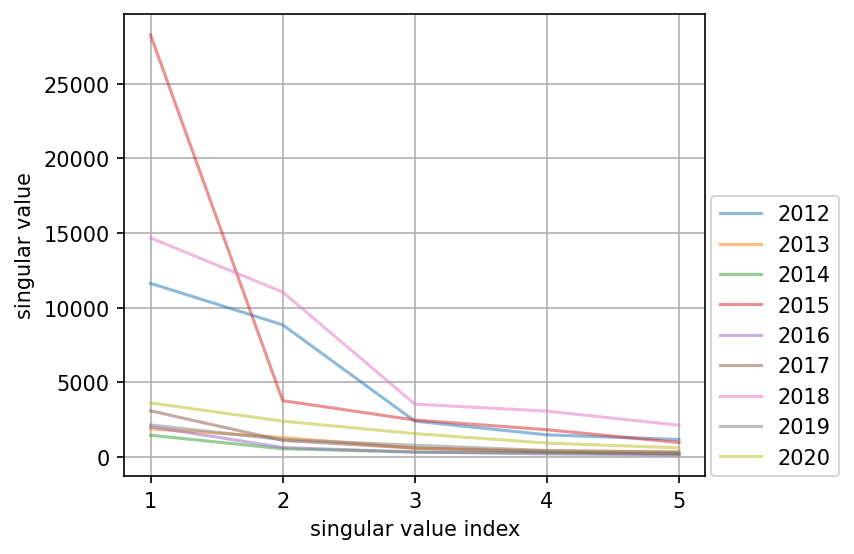

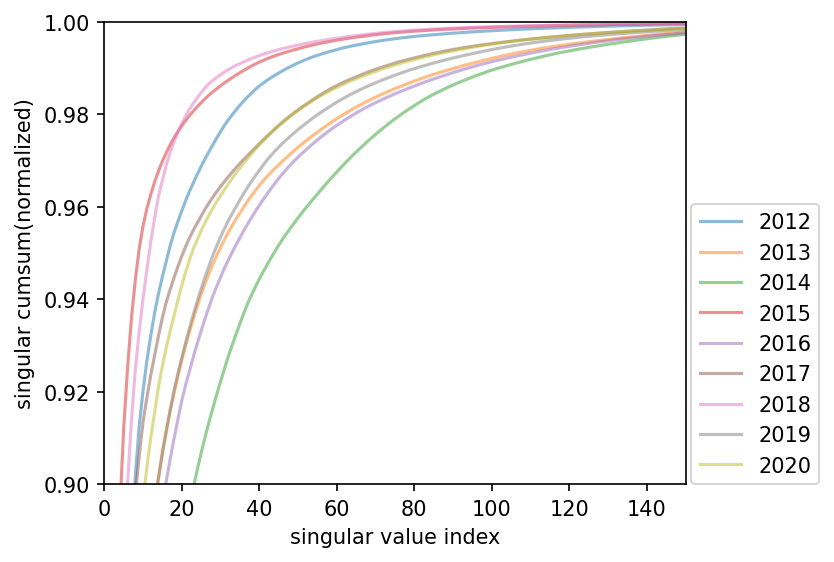

In [8]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_ebtimeF_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': 0.46882739126864637,
 '2013': 0.46297571668501103,
 '2014': 0.46432941514132575,
 '2015': 0.485812143761151,
 '2016': 0.46455903133196075,
 '2017': 0.4636361990094394,
 '2018': 0.48728600061415617,
 '2019': 0.4650025419339191,
 '2020': 0.48979090001029524}

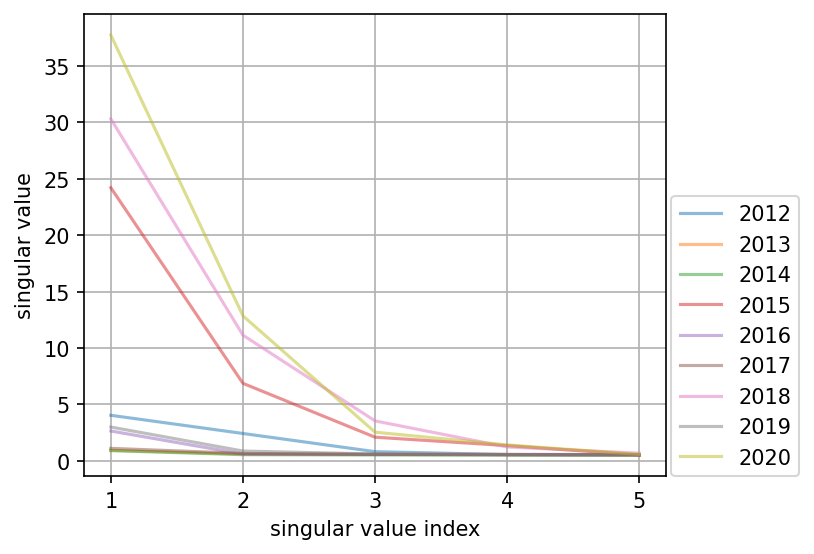

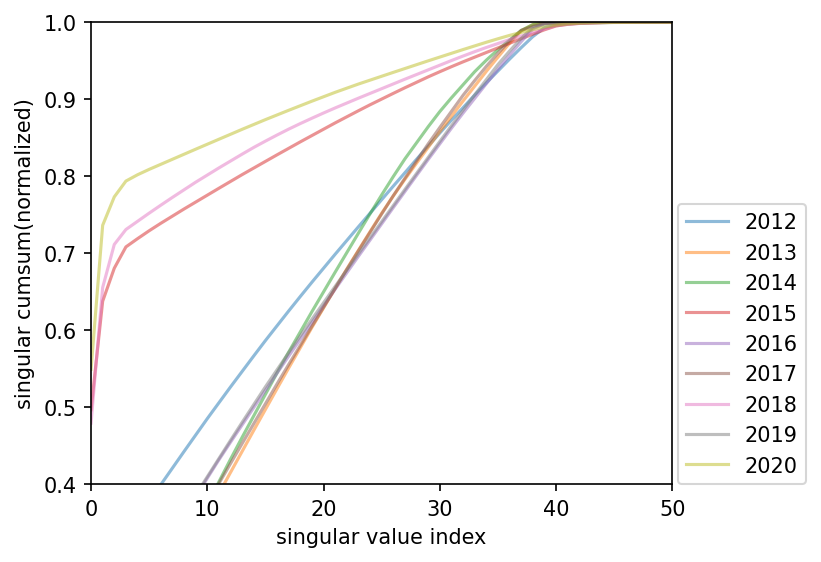

In [13]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.001_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=True)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

{'2012': 0.4888285402201138,
 '2013': 0.47988910520051764,
 '2014': 0.4837338777626421,
 '2015': 0.49367503342943186,
 '2016': 0.4826291302058978,
 '2017': 0.4790586287605122,
 '2018': 0.49257027250696517,
 '2019': 0.48480844346317176,
 '2020': 0.4943837218406518}

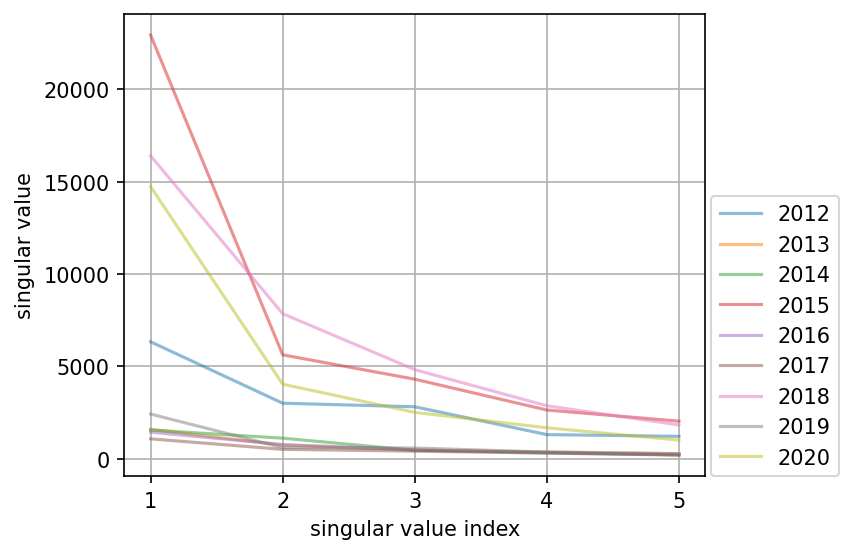

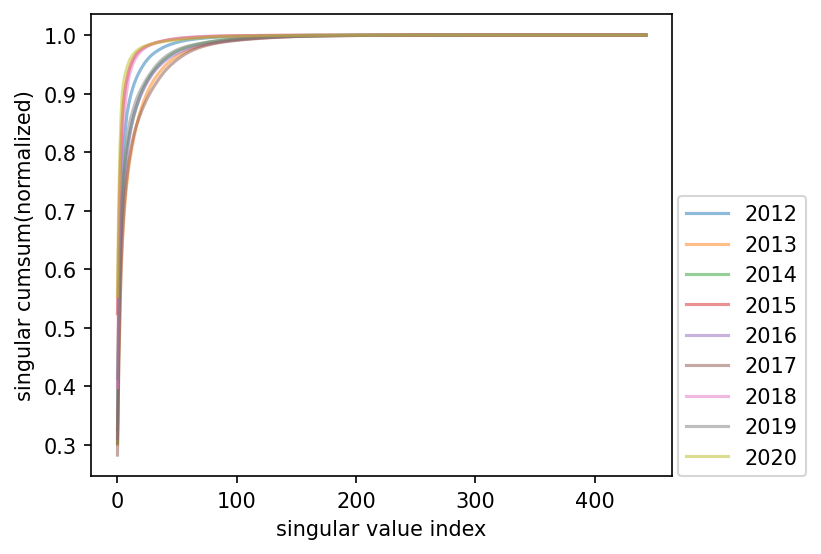

In [4]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.0_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': 0.4630018170385376,
 '2013': 0.46224250516682075,
 '2014': 0.4624851810271845,
 '2015': 0.46182952496477014,
 '2016': 0.4626919236088003,
 '2017': 0.46411287126077316,
 '2018': 0.46191611936155363,
 '2019': 0.463875109049132,
 '2020': 0.4615913403378955}

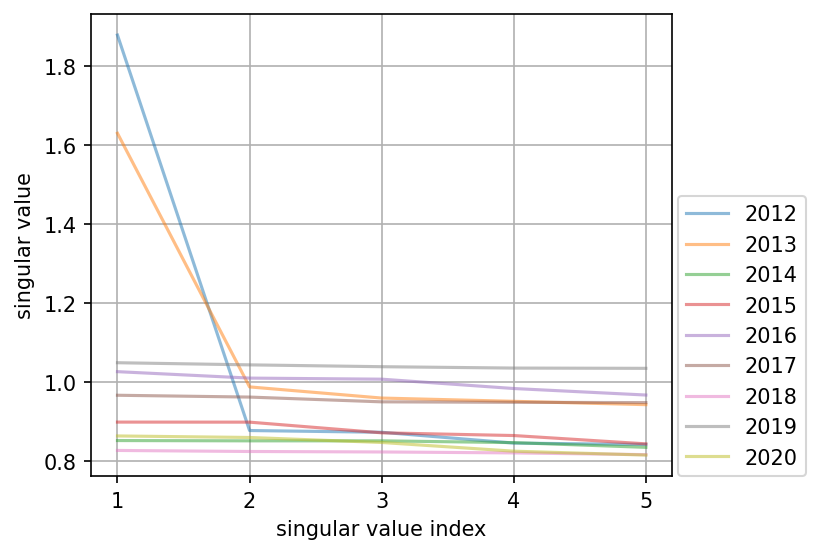

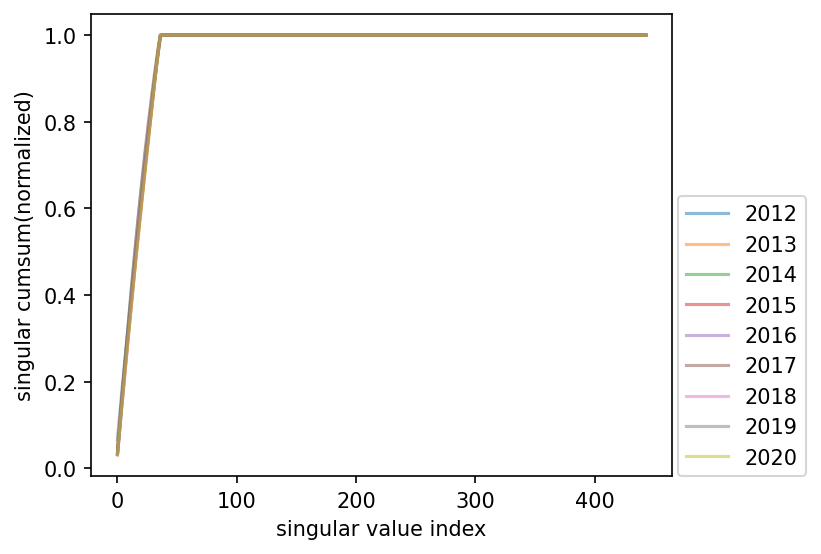

In [6]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.02_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=True)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

{'2012': 0.48590747474373874,
 '2013': 0.4895152647380705,
 '2014': 0.46569377657198396,
 '2015': 0.4959524702032144,
 '2016': 0.46579055763141886,
 '2017': 0.48178316621690553,
 '2018': 0.49992940912820594,
 '2019': 0.4847818354772516,
 '2020': 0.46905325741605775}

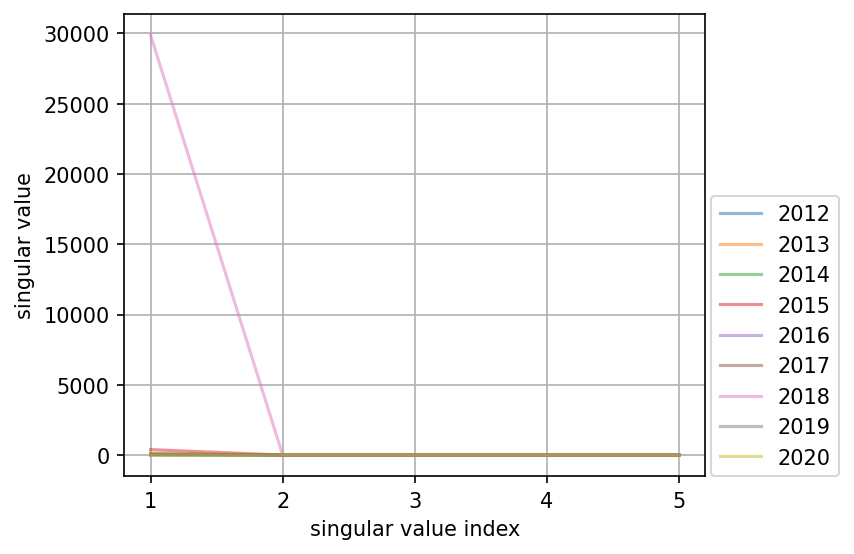

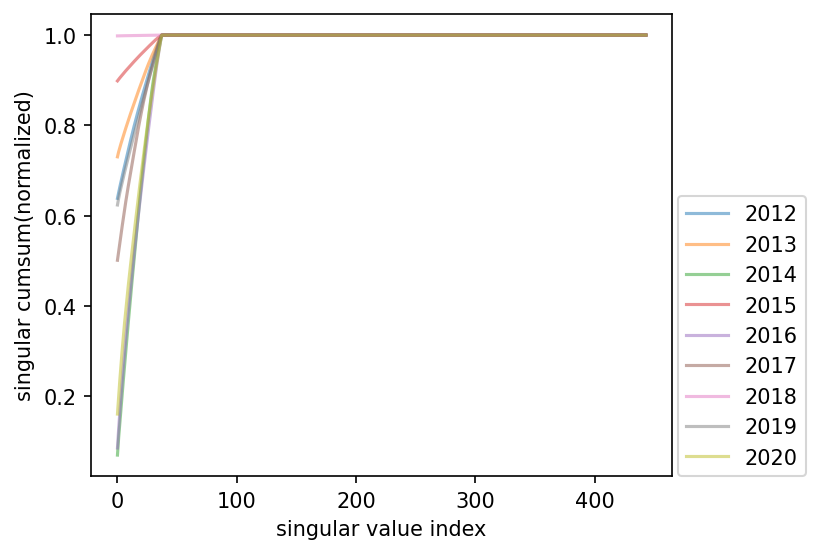

In [8]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_lam0.0005_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=True)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

{'2012': 0.4192268132761324,
 '2013': 0.39242569156887785,
 '2014': 0.3960491861568777,
 '2015': 0.43173446719029285,
 '2016': 0.3922501151393507,
 '2017': 0.3895384748438233,
 '2018': 0.43391443776061167,
 '2019': 0.3956114377996274,
 '2020': 0.4202196331490061}

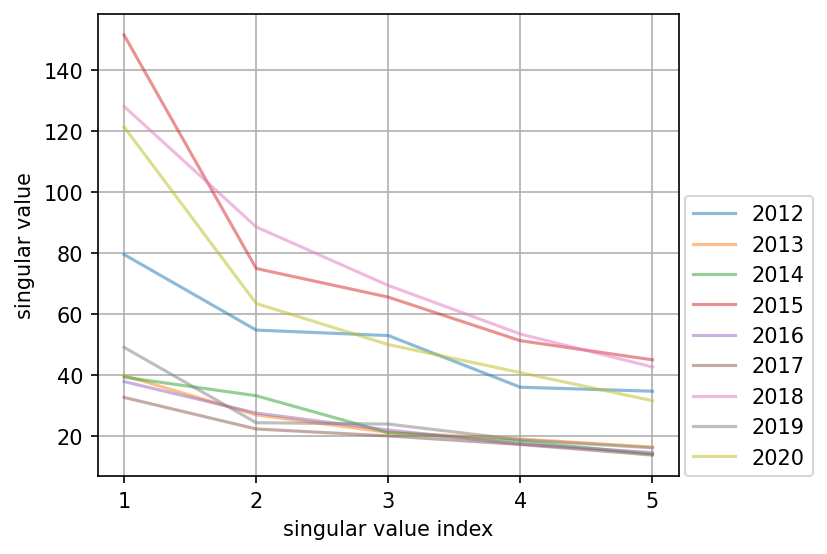

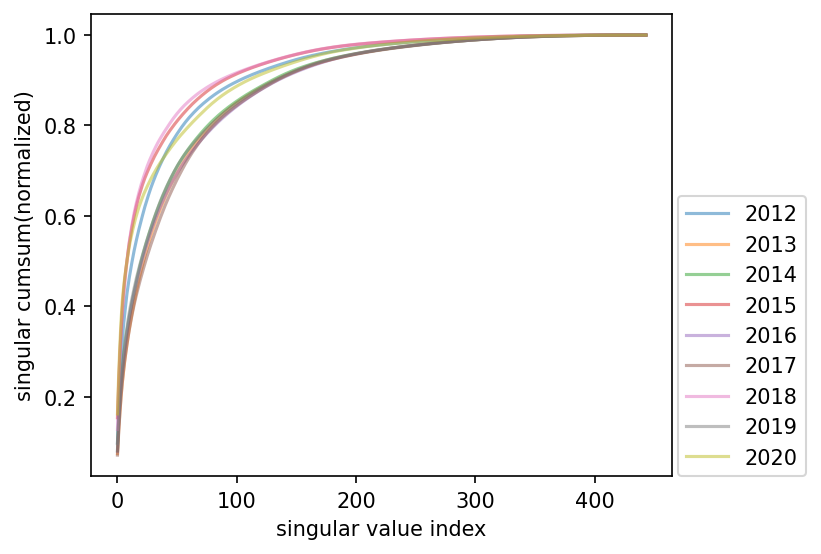

In [9]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_cov_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_ebtimeF_dtTrue_Exp_'
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': 0.4235649840392566,
 '2013': 0.3923815865379351,
 '2014': 0.3846927954140963,
 '2015': 0.428357511175966,
 '2016': 0.386683695297121,
 '2017': 0.40092965154105975,
 '2018': 0.4366641201868796,
 '2019': 0.397507267454158,
 '2020': 0.4039684926087005}

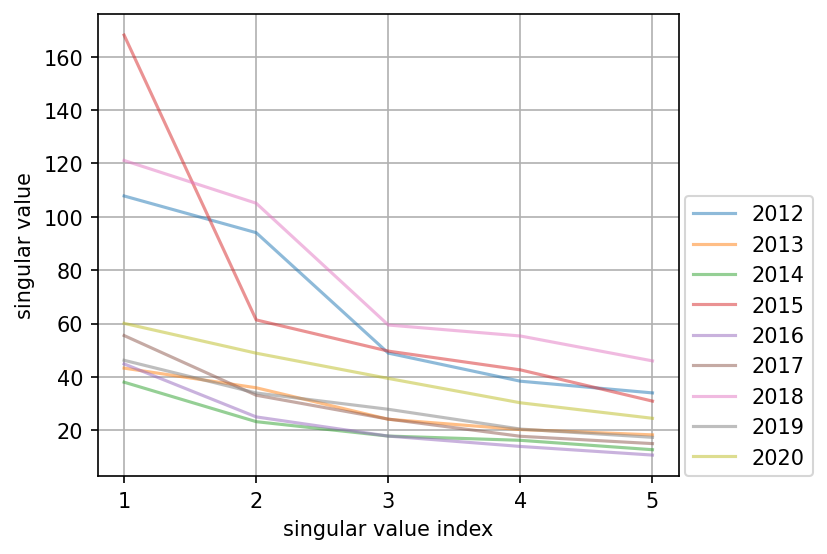

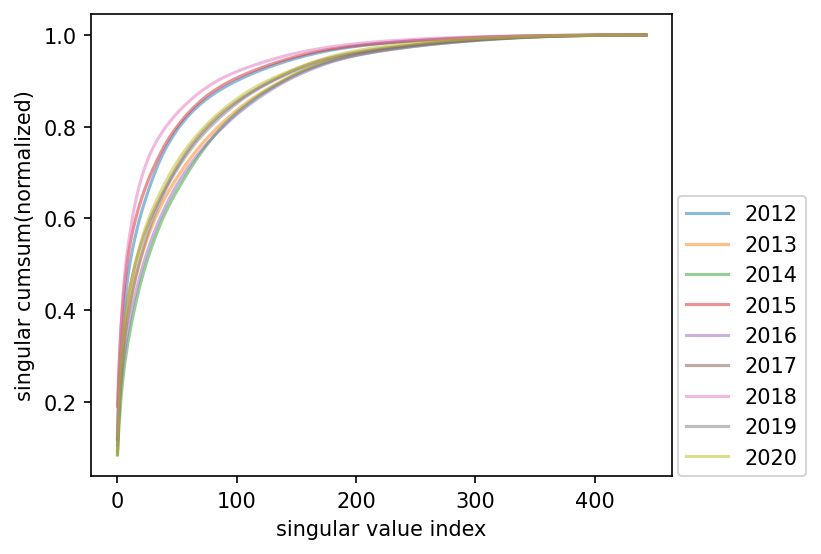

In [5]:
test_id = 'long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_floc0_ebtimeF_dtTrue_Exp_'
test_id0 = 'nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_'
#test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
plot_singular(test_id, seeds = 1, length=12, window=5, sigmas=False)
#plot_singular(test_id0, seeds = 1, length=12, window=5, sigmas=False)
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
#gn_dic0 = plot_singular_cum(test_id0, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': np.float64(0.4127916855838143),
 '2013': np.float64(0.4034898068651721),
 '2014': np.float64(0.39813582384693424),
 '2015': np.float64(0.4133884032923364),
 '2016': np.float64(0.3958277977029685),
 '2017': np.float64(0.3965376226459141),
 '2018': np.float64(0.4122596433601924),
 '2019': np.float64(0.40057195660876466),
 '2020': np.float64(0.4043368074273893)}

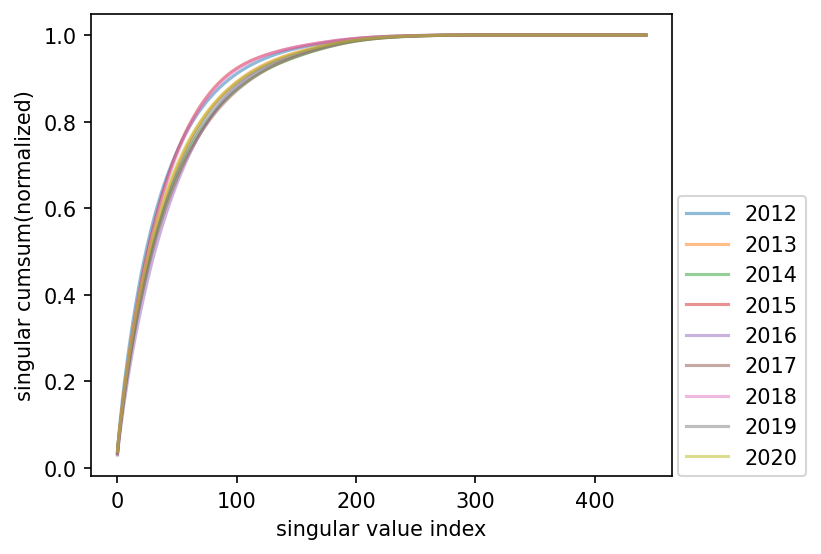

In [4]:
test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=False)
gn_dic

{'2012': np.float64(0.4632452635422548),
 '2013': np.float64(0.47986298006084493),
 '2014': np.float64(0.46125682415531477),
 '2015': np.float64(0.4672404643840503),
 '2016': np.float64(0.4290361281506142),
 '2017': np.float64(0.4374336897944233),
 '2018': np.float64(0.449221766773663),
 '2019': np.float64(0.4295127090329538),
 '2020': np.float64(0.437953179509767)}

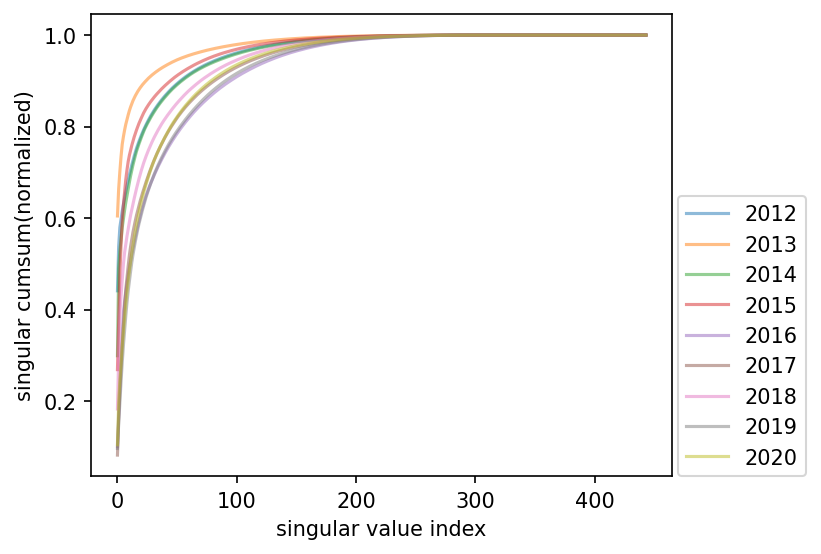

In [5]:
test_id = "nn_forecast_data_mean_996_37_NN_QBO_ftM_sl12_pl12_dm256_nh8_el2_dl1_df2048_fc1_floc1_ebtimeF_dtTrue_Exp_"
gn_dic = plot_singular_cum(test_id, seeds=1, length=12, window=444, sigmas=True)
gn_dic

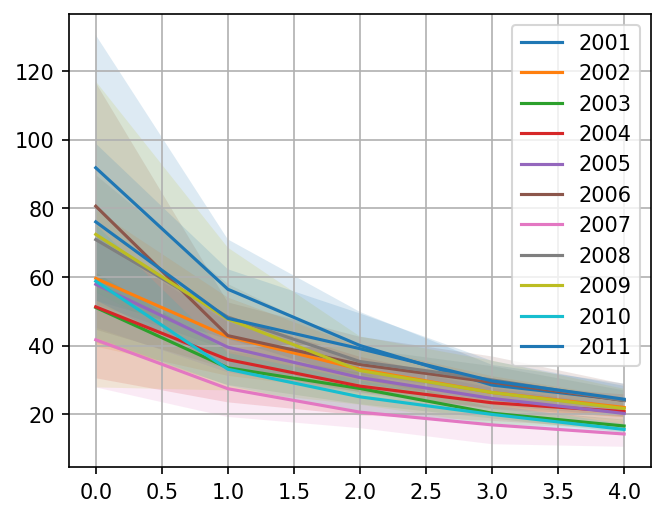

In [67]:
jacs = {i:[] for i in range(720, 852, 12)}
seeds = 10
for expid in range(seeds):
    test_id = "long_term_forecast_data_mean_996_37_iTransformer_QBO_ftM_sl12_pl12_dm512_nh8_el4_dl1_df512_fc3_ebtimeF_dtTrue_Exp_"+str(expid)
    for i in range(720, 852, 12):
        str_i = f'{i:04d}'
        mat = np.load(f'../results/jacobian/{test_id}/jac_{str_i}.npy').reshape(12*36, -1).astype(float)
        u, s, vt = np.linalg.svd(mat)
        jacs[i].append(s) 

plt.figure(figsize=(5,4),dpi=150)
for i in range(720, 852, 12):
    jac_arr = np.array(jacs[i])
    jac_mean = np.mean(jac_arr, axis=0)
    jac_std = np.std(jac_arr, axis=0)
    
    
    plt.plot(jac_mean[:5], label=str(1941+i//12))
    plt.fill_between(range(5), jac_mean[:5]+jac_std[:5], jac_mean[:5]-jac_std[:5], alpha=0.15)
plt.grid()
plt.legend()